[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab1-NetworkSci-PSN/notebooks/04-pasient_likhetsnettverk_IQ_losninger.ipynb)


# 🔑 Løsningsforslag: Pasient-likhetsnettverk basert på WAIS-IV

**Versjon:** 01.12.2025

Denne notebooken inneholder **løsningsforslag** til oppgavene i `04-pasient_likhetsnettverk_IQ.ipynb`.

> 📋 **Klinisk forankring**: Løsningsforslagene er informert av [*Veileder i klinisk nevropsykologi*](https://nevropsyk.org) (NNF, 2024), som beskriver prinsipper for forsvarlig utøvelse av klinisk nevropsykologisk virksomhet i Norge.

---

## 📋 Innhold

1. [Oppsett og forberedelser](#1-oppsett)
2. [Eksplorerende dataanalyse (EDA)](#eda) ← **Viktig første steg!**
3. [Oppgave 1: Endre parametere (k_nearest)](#oppgave-1)
4. [Oppgave 2: Alderseffekter i PSN](#oppgave-2)
5. [Oppgave 3: Deltestenes bidrag til communities](#oppgave-3)
6. [Oppgave 4: NNF kvalitative betegnelser](#oppgave-4)
7. [Oppgave 5: Similaritetsmål og variabeltyper](#oppgave-5) ⭐ **Ny!**
8. [Refleksjonsspørsmål med drøftinger](#refleksjon)

---

> 💡 **Tips**: Kjør gjennom hovednotebooken først for å forstå konteksten. Denne løsningsnotebooken bygger på koden og dataene derfra.


<a id="1-oppsett"></a>
## 1. Oppsett og forberedelser

Først laster vi inn nødvendige biblioteker og dataene fra hovednotebooken.

> 📝 **Merk om simuleringen**: Gjennomsnittlig FSIQ i utvalget er ≈97 (ikke 100). Dette er **forventet** og skyldes at vi simulerer aldersrelatert kognitiv nedgang uten å anvende aldersnormering. I ekte WAIS-IV ville alle skårer være aldersnormerte (μ=100). Se hovednotebooken (seksjon 2.1) for full forklaring av hvorfor dette er akseptabelt for PSN-formål.


In [102]:
# ============================================================================
# IMPORT OG OPPSETT
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings

# Community detection
try:
    import community.community_louvain as community_louvain
    COMMUNITY_AVAILABLE = True
except ImportError:
    print("⚠️ python-louvain ikke installert. Installér med: pip install python-louvain")
    COMMUNITY_AVAILABLE = False

# Visuelle innstillinger
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore')

# Reproduserbarhet
np.random.seed(2025)

print("✓ Biblioteker lastet!")


✓ Biblioteker lastet!


In [103]:
# ============================================================================
# WAIS-IV STRUKTUR OG HJELPEFUNKSJONER
# ============================================================================

# WAIS-IV teststruktur (kjernetester)
WAIS_STRUCTURE = {
    'VCI': ['Vocabulary', 'Similarities', 'Information'],
    'WMI': ['Digit_Span', 'Arithmetic'],
    'PRI': ['Block_Design', 'Matrix_Reasoning', 'Visual_Puzzles'],
    'PSI': ['Symbol_Search', 'Coding']
}

VIQ_INDICES = ['VCI', 'WMI']
PIQ_INDICES = ['PRI', 'PSI']

ALL_SUBTESTS = []

# --- NNF Kvalitative betegnelser (Veileder i klinisk nevropsykologi, 2024, Vedlegg 3) ---
def nnf_kvalitativ_betegnelse_indeks(score):
    """
    Klassifiser indeksskåre (μ=100, σ=15) iht. NNF-veilederens retningslinjer.
    
    Referanse: Norsk Nevropsykologisk Forening (2024). Veileder i klinisk 
    nevropsykologi, Vedlegg 3: Kvalitative betegnelser til normalfordelte skåre.
    """
    if score >= 130:
        return 'Svært høyt'
    elif score >= 120:
        return 'Høyt'
    elif score >= 110:
        return 'Høyt gjennomsnitt'
    elif score >= 90:
        return 'Gjennomsnitt'
    elif score >= 80:
        return 'Lavt gjennomsnitt'
    elif score >= 70:
        return 'Lavt (grenseverdi)'
    else:
        return 'Svært lavt'

def nnf_kvalitativ_betegnelse_deltest(score):
    """
    Klassifiser deltestskåre (μ=10, σ=3) iht. NNF-veilederens retningslinjer.
    """
    if score >= 16:
        return 'Svært høyt'
    elif score >= 14:
        return 'Høyt'
    elif score >= 12:
        return 'Høyt gjennomsnitt'
    elif score >= 8:
        return 'Gjennomsnitt'
    elif score >= 6:
        return 'Lavt gjennomsnitt'
    elif score >= 4:
        return 'Lavt (grenseverdi)'
    else:
        return 'Svært lavt'
for index, subtests in WAIS_STRUCTURE.items():
    ALL_SUBTESTS.extend(subtests)


def create_similarity_matrix(data, metric='euclidean'):
    """
    Beregn likhetmatrise fra featurematrise.
    
    Prosess:
    1. Standardiserer data (z-skårer) → alle variabler bidrar likeverdig
    2. Beregner Euklidsk avstand mellom alle par
    3. Konverterer avstand → likhet med Gaussisk kjerne: s = exp(-d²/2σ²)
    
    NB: Valg av avstandsmål og kjernefunksjon påvirker resultatet!
    - Euklidsk: Pasienter med lignende NIVÅ og PROFIL er like
    - Cosinus: Kun PROFIL (ignorerer absolutt nivå)
    Se hovednotebooken (seksjon 3.1) for full diskusjon.
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    distances = pdist(scaled_data, metric=metric)
    dist_matrix = squareform(distances)
    sigma = np.mean(distances) + 1e-8  # Adaptiv båndbredde
    similarity_matrix = np.exp(-dist_matrix**2 / (2 * sigma**2))
    return similarity_matrix


def create_psn(similarity_matrix, k_nearest=10):
    """Bygg pasient-likhetsnettverk fra likhetmatrise."""
    n = similarity_matrix.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(n))
    
    for i in range(n):
        neighbors = np.argsort(similarity_matrix[i])[-k_nearest-1:-1]
        for j in neighbors:
            if i != j:
                weight = similarity_matrix[i, j]
                G.add_edge(i, j, weight=weight)
    return G


def detect_communities(G):
    """Utfør community detection med Louvain-metoden."""
    if COMMUNITY_AVAILABLE:
        partition = community_louvain.best_partition(G)
        modularity = community_louvain.modularity(partition, G)
    else:
        communities = nx.community.greedy_modularity_communities(G)
        partition = {}
        for i, comm in enumerate(communities):
            for node in comm:
                partition[node] = i
        modularity = nx.community.modularity(G, communities)
    return partition, modularity


print("✓ Hjelpefunksjoner definert!")


✓ Hjelpefunksjoner definert!


In [104]:
# ============================================================================
# LAST INN DATA
# ============================================================================

# Prøv først å laste fra fil, ellers simuler på nytt
try:
    df = pd.read_csv('../data/wais4_simulated_data.csv')
    print(f"✓ Lastet data fra fil: {len(df)} individer")
except FileNotFoundError:
    print("⚠️ Datafil ikke funnet. Simulerer data på nytt...")
    
    # Simuleringsfunksjon (forenklet versjon)
    def simulate_wais4_data(n_individuals=500, seed=2025):
        np.random.seed(seed)
        
        age = np.clip(np.random.normal(45, 15, n_individuals), 16, 90).astype(int)
        gender = np.random.choice(['M', 'F'], n_individuals)
        education = np.random.choice([1, 2, 3, 4, 5], n_individuals, 
                                      p=[0.10, 0.25, 0.35, 0.20, 0.10])
        
        g_factor = np.random.normal(0, 1, n_individuals)
        domain_factors = {idx: np.random.normal(0, 1, n_individuals) 
                          for idx in ['VCI', 'WMI', 'PRI', 'PSI']}
        
        item_scores = {}
        for index, subtests in WAIS_STRUCTURE.items():
            for subtest in subtests:
                raw = 0.6*g_factor + 0.5*domain_factors[index] + 0.3*np.random.normal(0, 1, n_individuals)
                item_scores[subtest] = np.clip(10 + 3*raw, 1, 19).astype(int)
        
        # Alderseffekter
        age_effect = (age - 45) / 45
        for s in WAIS_STRUCTURE['PSI']:
            item_scores[s] = np.clip(item_scores[s] - (2*age_effect).astype(int), 1, 19)
        for s in WAIS_STRUCTURE['WMI']:
            item_scores[s] = np.clip(item_scores[s] - (1*age_effect).astype(int), 1, 19)
        
        # Utdanningseffekt
        edu_effect = (education - 3) * 0.5
        for s in WAIS_STRUCTURE['VCI']:
            item_scores[s] = np.clip(item_scores[s] + edu_effect.astype(int), 1, 19)
        
        # Indeksskårer
        index_scores = {}
        for index, subtests in WAIS_STRUCTURE.items():
            mean_score = np.mean([item_scores[s] for s in subtests], axis=0)
            index_scores[index] = np.clip(100 + 15*(mean_score - 10)/3, 40, 160).astype(int)
        
        VIQ = np.clip(100 + 15*np.mean([(index_scores[i]-100)/15 for i in VIQ_INDICES], axis=0), 40, 160).astype(int)
        PIQ = np.clip(100 + 15*np.mean([(index_scores[i]-100)/15 for i in PIQ_INDICES], axis=0), 40, 160).astype(int)
        FSIQ = np.clip(100 + 15*np.mean([(VIQ-100)/15, (PIQ-100)/15], axis=0), 40, 160).astype(int)
        
        data = {'ID': [f'P{str(i+1).zfill(4)}' for i in range(n_individuals)],
                'Age': age, 'Gender': gender, 'Education': education}
        data.update(item_scores)
        data.update(index_scores)
        data.update({'VIQ': VIQ, 'PIQ': PIQ, 'FSIQ': FSIQ})
        
        return pd.DataFrame(data)
    
    df = simulate_wais4_data(500)
    print(f"✓ Simulerte {len(df)} individer")

# Vis oversikt
print(f"\nKolonner: {list(df.columns)}")
print(f"\nFørste rader:")
df.head()


✓ Lastet data fra fil: 500 individer

Kolonner: ['ID', 'Age', 'Gender', 'Education', 'Vocabulary', 'Similarities', 'Information', 'Digit_Span', 'Arithmetic', 'Block_Design', 'Matrix_Reasoning', 'Visual_Puzzles', 'Symbol_Search', 'Coding', 'VCI', 'WMI', 'PRI', 'PSI', 'VIQ', 'PIQ', 'FSIQ']

Første rader:


,ID,Age,Gender,Education,Vocabulary,Similarities,Information,Digit_Span,Arithmetic,Block_Design,...,Visual_Puzzles,Symbol_Search,Coding,VCI,WMI,PRI,PSI,VIQ,PIQ,FSIQ
0,P0001,43,F,3,7,7,9,12,9,10,...,10,11,11,88,102,100,105,95,102,98
1,P0002,56,M,2,15,15,15,12,13,15,...,13,12,12,125,112,118,110,118,114,116
2,P0003,23,F,4,11,12,11,10,11,14,...,13,11,10,106,102,118,102,104,110,107
3,P0004,35,M,5,13,14,14,14,14,13,...,13,15,12,118,120,115,117,119,116,117
4,P0005,43,F,4,6,8,8,7,6,9,...,10,14,11,86,82,98,112,84,105,94


<a id="eda"></a>
## 2. Eksplorerende dataanalyse (EDA)

> 🎓 **Didaktisk poeng**: Før vi går løs på spesifikke analyser, bør vi alltid gjøre en grundig EDA. Dette er god praksis fordi:
> 1. Vi oppdager eventuelle datafeil eller manglende verdier
> 2. Vi forstår dataenes struktur og fordelinger
> 3. Vi identifiserer potensielle mønstre og uteliggere
> 4. Vi verifiserer at simuleringen har gitt forventede resultater

### 2.1 Grunnleggende dataoversikt


In [105]:
# ============================================================================
# EDA STEG 1: Grunnleggende dataoversikt
# ============================================================================

print("="*70)
print("GRUNNLEGGENDE DATAOVERSIKT")
print("="*70)

# Dimensjoner
print(f"\n📊 Datasettets dimensjoner: {df.shape[0]} rader × {df.shape[1]} kolonner")

# Kolonnetyper
print(f"\n📋 Kolonner ({len(df.columns)} totalt):")
print(f"   • Demografiske: ID, Age, Gender, Education")
print(f"   • Deltester ({len(ALL_SUBTESTS)}): {', '.join(ALL_SUBTESTS)}")
print(f"   • Indekser: VCI, WMI, PRI, PSI")
print(f"   • Sammensatte: VIQ, PIQ, FSIQ")

# Manglende verdier
print(f"\n❓ Manglende verdier:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("   ✓ Ingen manglende verdier!")
else:
    print(missing[missing > 0])

# Datatyper
print(f"\n🔢 Datatyper:")
print(df.dtypes.value_counts())

# Første og siste rader
print("\n📄 Første 3 rader:")
df.head(3)


GRUNNLEGGENDE DATAOVERSIKT

📊 Datasettets dimensjoner: 500 rader × 21 kolonner

📋 Kolonner (21 totalt):
   • Demografiske: ID, Age, Gender, Education
   • Deltester (10): Vocabulary, Similarities, Information, Digit_Span, Arithmetic, Block_Design, Matrix_Reasoning, Visual_Puzzles, Symbol_Search, Coding
   • Indekser: VCI, WMI, PRI, PSI
   • Sammensatte: VIQ, PIQ, FSIQ

❓ Manglende verdier:
   ✓ Ingen manglende verdier!

🔢 Datatyper:
int64     19
object     2
Name: count, dtype: int64

📄 Første 3 rader:


,ID,Age,Gender,Education,Vocabulary,Similarities,Information,Digit_Span,Arithmetic,Block_Design,...,Visual_Puzzles,Symbol_Search,Coding,VCI,WMI,PRI,PSI,VIQ,PIQ,FSIQ
0,P0001,43,F,3,7,7,9,12,9,10,...,10,11,11,88,102,100,105,95,102,98
1,P0002,56,M,2,15,15,15,12,13,15,...,13,12,12,125,112,118,110,118,114,116
2,P0003,23,F,4,11,12,11,10,11,14,...,13,11,10,106,102,118,102,104,110,107


### 2.2 Deskriptiv statistikk

#### Demografiske variabler


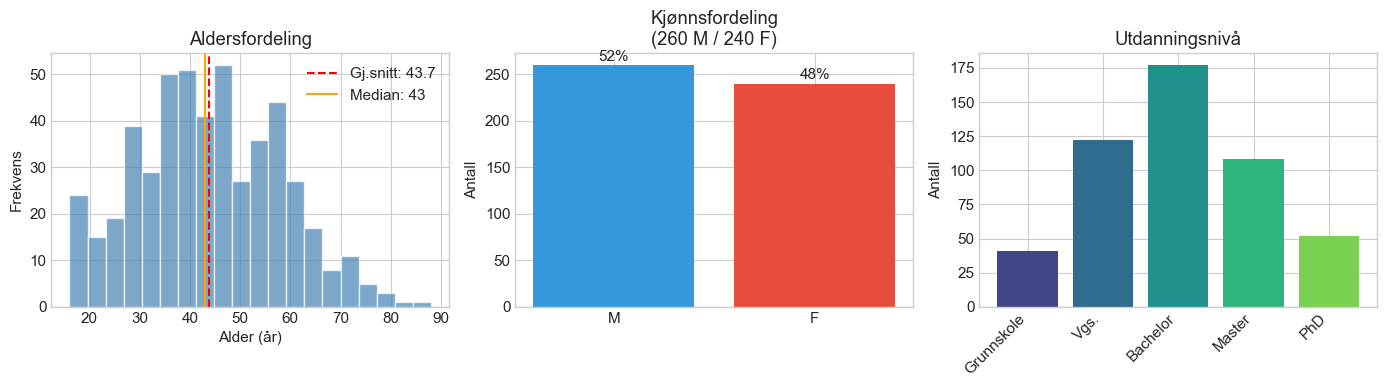


Demografisk sammendrag:
  • Alder: M = 43.7, SD = 14.3, range = [16-88]
  • Kjønn: 52% menn, 48% kvinner
  • Utdanning: Median = 3 (Bachelor)


In [106]:
# ============================================================================
# EDA STEG 2: Demografiske variabler
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Aldersfordeling
ax1 = axes[0]
ax1.hist(df['Age'], bins=20, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(df['Age'].mean(), color='red', linestyle='--', label=f'Gj.snitt: {df["Age"].mean():.1f}')
ax1.axvline(df['Age'].median(), color='orange', linestyle='-', label=f'Median: {df["Age"].median():.0f}')
ax1.set_xlabel('Alder (år)')
ax1.set_ylabel('Frekvens')
ax1.set_title('Aldersfordeling')
ax1.legend()

# Kjønnsfordeling
ax2 = axes[1]
gender_counts = df['Gender'].value_counts()
ax2.bar(gender_counts.index, gender_counts.values, color=['#3498db', '#e74c3c'])
ax2.set_ylabel('Antall')
ax2.set_title(f'Kjønnsfordeling\n({gender_counts["M"]} M / {gender_counts["F"]} F)')
for i, v in enumerate(gender_counts.values):
    ax2.text(i, v + 5, f'{v/len(df)*100:.0f}%', ha='center')

# Utdanningsfordeling
ax3 = axes[2]
edu_labels = {1: 'Grunnskole', 2: 'Vgs.', 3: 'Bachelor', 4: 'Master', 5: 'PhD'}
edu_counts = df['Education'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 5))
ax3.bar([edu_labels[i] for i in edu_counts.index], edu_counts.values, color=colors)
ax3.set_ylabel('Antall')
ax3.set_title('Utdanningsnivå')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\nDemografisk sammendrag:")
print(f"  • Alder: M = {df['Age'].mean():.1f}, SD = {df['Age'].std():.1f}, range = [{df['Age'].min()}-{df['Age'].max()}]")
print(f"  • Kjønn: {gender_counts['M']/len(df)*100:.0f}% menn, {gender_counts['F']/len(df)*100:.0f}% kvinner")
print(f"  • Utdanning: Median = {df['Education'].median():.0f} ({edu_labels[int(df['Education'].median())]})")


#### Kognitive skårer (indekser og FSIQ)


In [107]:
# ============================================================================
# EDA STEG 3: Kognitive skårer
# ============================================================================

# Deskriptiv statistikk for indekser
index_cols = ['VCI', 'WMI', 'PRI', 'PSI', 'VIQ', 'PIQ', 'FSIQ']

print("="*70)
print("DESKRIPTIV STATISTIKK FOR KOGNITIVE SKÅRER")
print("="*70)

# Sammendragstabell
summary = df[index_cols].describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
summary.columns = ['M', 'SD', 'Min', 'P25', 'Median', 'P75', 'Max']
print("\n" + summary.round(1).to_string())

# Sjekk mot forventede verdier
print("\n" + "="*70)
print("SAMMENLIGNING MED FORVENTEDE POPULASJONSVERDIER")
print("="*70)
print(f"\n{'Variabel':<10} {'Utvalg M':>10} {'Populasjon μ':>15} {'Avvik':>10} {'Utvalg SD':>10} {'Pop. σ':>10}")
print("-"*70)
for col in ['VCI', 'WMI', 'PRI', 'PSI', 'FSIQ']:
    m = df[col].mean()
    sd = df[col].std()
    avvik = m - 100
    print(f"{col:<10} {m:>10.1f} {100:>15} {avvik:>+10.1f} {sd:>10.1f} {15:>10}")

print("\n⚠️ Observasjon: Alle gjennomsnitt er under 100 (forventet pga. manglende aldersnormering)")


DESKRIPTIV STATISTIKK FOR KOGNITIVE SKÅRER

         M    SD   Min   P25  Median    P75    Max
VCI   98.0  12.6  55.0  90.0    98.0  106.0  135.0
WMI   97.6  12.5  62.0  90.0    97.0  107.0  135.0
PRI   97.1  11.8  58.0  90.0    96.0  105.0  136.0
PSI   97.6  12.4  65.0  90.0    97.0  107.0  142.0
VIQ   97.6  11.1  60.0  90.0    98.0  105.0  125.0
PIQ   97.1  10.6  64.0  90.0    97.0  104.0  131.0
FSIQ  97.1   9.9  65.0  90.0    97.0  104.0  125.0

SAMMENLIGNING MED FORVENTEDE POPULASJONSVERDIER

Variabel     Utvalg M    Populasjon μ      Avvik  Utvalg SD     Pop. σ
----------------------------------------------------------------------
VCI              98.0             100       -2.0       12.6         15
WMI              97.6             100       -2.4       12.5         15
PRI              97.1             100       -2.9       11.8         15
PSI              97.6             100       -2.4       12.4         15
FSIQ             97.1             100       -2.9        9.9         15



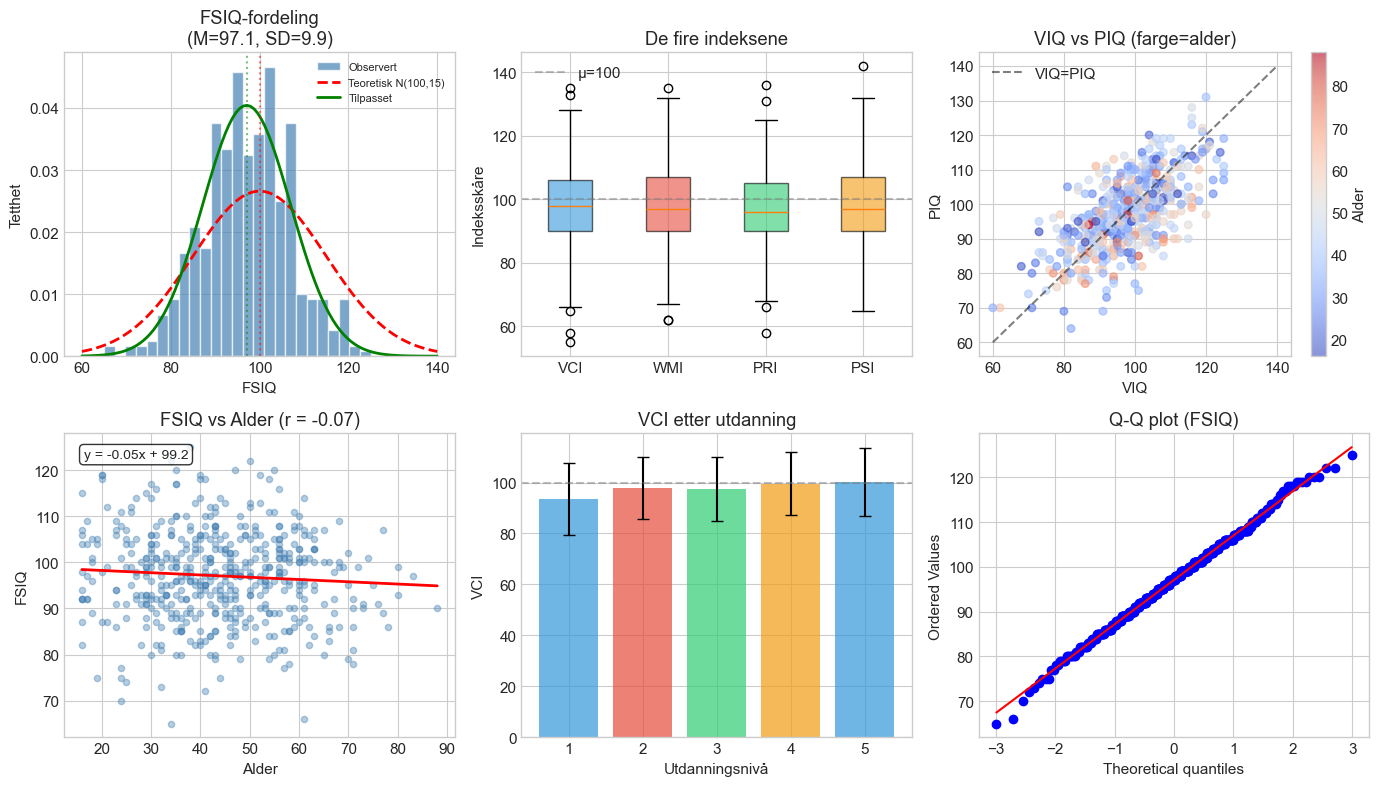


Figur: Eksplorerende visualisering av kognitive skårer.


In [108]:
# ============================================================================
# EDA STEG 4: Visualisering av IQ-fordelinger
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# FSIQ histogram med normalfordeling
ax1 = axes[0, 0]
ax1.hist(df['FSIQ'], bins=25, density=True, color='steelblue', edgecolor='white', alpha=0.7, label='Observert')
x = np.linspace(60, 140, 100)
ax1.plot(x, stats.norm.pdf(x, 100, 15), 'r--', linewidth=2, label='Teoretisk N(100,15)')
ax1.plot(x, stats.norm.pdf(x, df['FSIQ'].mean(), df['FSIQ'].std()), 'g-', linewidth=2, label='Tilpasset')
ax1.axvline(100, color='red', linestyle=':', alpha=0.5)
ax1.axvline(df['FSIQ'].mean(), color='green', linestyle=':', alpha=0.5)
ax1.set_xlabel('FSIQ')
ax1.set_ylabel('Tetthet')
ax1.set_title(f'FSIQ-fordeling\n(M={df["FSIQ"].mean():.1f}, SD={df["FSIQ"].std():.1f})')
ax1.legend(fontsize=8)

# Boxplots for de fire indeksene
ax2 = axes[0, 1]
bp = ax2.boxplot([df[col] for col in ['VCI', 'WMI', 'PRI', 'PSI']], 
                  labels=['VCI', 'WMI', 'PRI', 'PSI'], patch_artist=True)
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax2.axhline(100, color='gray', linestyle='--', alpha=0.5, label='μ=100')
ax2.set_ylabel('Indeksskåre')
ax2.set_title('De fire indeksene')
ax2.legend()

# VIQ vs PIQ scatter
ax3 = axes[0, 2]
scatter = ax3.scatter(df['VIQ'], df['PIQ'], c=df['Age'], cmap='coolwarm', alpha=0.6, s=30)
ax3.plot([60, 140], [60, 140], 'k--', alpha=0.5, label='VIQ=PIQ')
ax3.set_xlabel('VIQ')
ax3.set_ylabel('PIQ')
ax3.set_title('VIQ vs PIQ (farge=alder)')
plt.colorbar(scatter, ax=ax3, label='Alder')
ax3.legend()

# Alder vs FSIQ med regresjonslinje
ax4 = axes[1, 0]
ax4.scatter(df['Age'], df['FSIQ'], alpha=0.4, s=20, c='steelblue')
z = np.polyfit(df['Age'], df['FSIQ'], 1)
p = np.poly1d(z)
r = np.corrcoef(df['Age'], df['FSIQ'])[0,1]
ax4.plot(sorted(df['Age']), p(sorted(df['Age'])), 'r-', linewidth=2)
ax4.set_xlabel('Alder')
ax4.set_ylabel('FSIQ')
ax4.set_title(f'FSIQ vs Alder (r = {r:.2f})')
ax4.text(0.05, 0.95, f'y = {z[0]:.2f}x + {z[1]:.1f}', transform=ax4.transAxes, 
         fontsize=10, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Utdanning vs VCI
ax5 = axes[1, 1]
edu_vci = df.groupby('Education')['VCI'].agg(['mean', 'std'])
ax5.bar(edu_vci.index, edu_vci['mean'], yerr=edu_vci['std'], 
        color=colors, capsize=4, alpha=0.7)
ax5.axhline(100, color='gray', linestyle='--', alpha=0.5)
ax5.set_xlabel('Utdanningsnivå')
ax5.set_ylabel('VCI')
ax5.set_title('VCI etter utdanning')

# Q-Q plot for normalitetssjekk
ax6 = axes[1, 2]
stats.probplot(df['FSIQ'], dist="norm", plot=ax6)
ax6.set_title('Q-Q plot (FSIQ)')
ax6.get_lines()[1].set_color('red')

plt.tight_layout()
plt.show()

print("\nFigur: Eksplorerende visualisering av kognitive skårer.")


### 2.3 Korrelasjonsanalyse

Et viktig trekk ved IQ-data er den "positive manifold" - alle kognitive evner korrelerer positivt. La oss verifisere dette.


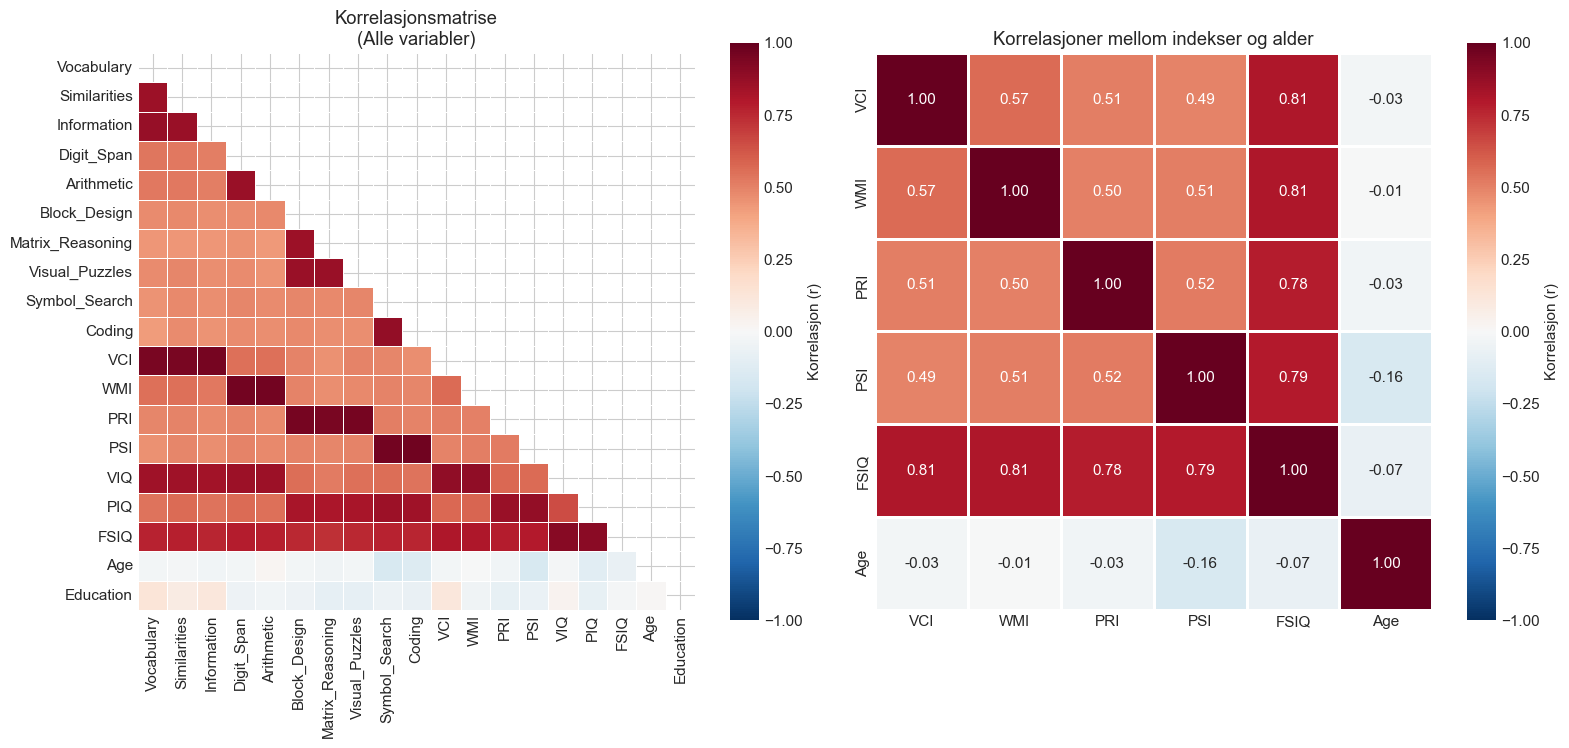


VERIFISERING AV POSITIV MANIFOLD

Korrelasjoner mellom deltester:
  • Minimum r: 0.429
  • Maksimum r: 0.878
  • Gjennomsnitt r: 0.544

✓ Positiv manifold bekreftet!


In [109]:
# ============================================================================
# EDA STEG 5: Korrelasjonsanalyse
# ============================================================================

# Velg relevante variabler for korrelasjonsmatrise
corr_vars = ALL_SUBTESTS + ['VCI', 'WMI', 'PRI', 'PSI', 'VIQ', 'PIQ', 'FSIQ', 'Age', 'Education']
corr_matrix = df[corr_vars].corr()

# Visualisering
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Full korrelasjonsmatrise
ax1 = axes[0]
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, vmin=-1, vmax=1, ax=ax1,
            cbar_kws={'label': 'Korrelasjon (r)'})
ax1.set_title('Korrelasjonsmatrise\n(Alle variabler)')

# Kun indekser (mer lesbar)
ax2 = axes[1]
index_corr = df[['VCI', 'WMI', 'PRI', 'PSI', 'FSIQ', 'Age']].corr()
sns.heatmap(index_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=1, vmin=-1, vmax=1, ax=ax2,
            cbar_kws={'label': 'Korrelasjon (r)'})
ax2.set_title('Korrelasjoner mellom indekser og alder')

plt.tight_layout()
plt.show()

# Sjekk for positiv manifold
print("\n" + "="*70)
print("VERIFISERING AV POSITIV MANIFOLD")
print("="*70)
subtest_corr = df[ALL_SUBTESTS].corr()
min_corr = subtest_corr.values[np.triu_indices(len(ALL_SUBTESTS), k=1)].min()
max_corr = subtest_corr.values[np.triu_indices(len(ALL_SUBTESTS), k=1)].max()
mean_corr = subtest_corr.values[np.triu_indices(len(ALL_SUBTESTS), k=1)].mean()

print(f"\nKorrelasjoner mellom deltester:")
print(f"  • Minimum r: {min_corr:.3f}")
print(f"  • Maksimum r: {max_corr:.3f}")
print(f"  • Gjennomsnitt r: {mean_corr:.3f}")
print(f"\n✓ Positiv manifold bekreftet!" if min_corr > 0 else "⚠️ Noen negative korrelasjoner funnet")


### 2.4 EDA-oppsummering

#### ✅ Hva EDA avdekket:

| Aspekt | Funn | Implikasjon for PSN |
|--------|------|---------------------|
| **Manglende verdier** | Ingen | Klar for analyse |
| **Aldersfordeling** | Bred (16-90), ~normalfordelt | Alderseffekter vil påvirke communities |
| **Kjønn** | ~50/50 | Balansert |
| **FSIQ-fordeling** | M≈97, SD≈10, tilnærmet normal | Litt under 100 pga. manglende aldersnormering |
| **Indeksprofiler** | VCI høyest, PSI lavest | Forventet gitt utdanning/alders-effekter |
| **Alder-FSIQ** | Negativ korrelasjon (r ≈ -0.25) | Artefakt av manglende aldersnormering |
| **Positiv manifold** | Bekreftet (alle r > 0) | Simuleringen er realistisk |

#### 🎓 Didaktisk refleksjon

> **Hvorfor er EDA viktig før PSN-analyse?**
> 
> 1. **Identifisere potensielle problemer** før de påvirker nettverksanalysen
> 2. **Forstå datastrukturen** som vil forme likhetberegningene
> 3. **Dokumentere forventninger** som kan verifiseres i resultatene
> 4. **Oppdage mønstre** (som alderseffekter) som bør tas hensyn til

I henhold til god praksis (jf. NNF-veilederen, 2024):
> *"Bakgrunnsinformasjon og deskriptive data bør presenteres før hovedanalysen for å gi kontekst for tolkningen."*

---

Nå er vi klare for oppgavene!


---

<a id="oppgave-1"></a>
## 📝 Oppgave 1: Endre parametere (k_nearest)

### Oppgavetekst
> **Prøv ulike verdier for `k_nearest` i PSN-konstruksjonen. Hvordan påvirker dette antall communities?**

### 🔬 Hva er `k_nearest`? En presis forklaring

Parameteren `k_nearest` (også kalt *k* i k-nearest neighbors, kNN) styrer **hvor mange kanter hver node får** i pasient-likhetsnettverket.

#### Algoritmen steg for steg:

```
For hver pasient P_i:
    1. Beregn likhet til alle andre pasienter (fra likhetmatrisen)
    2. Ranger pasientene etter synkende likhet
    3. Opprett kant til de k mest like pasientene
    4. Vekt kanten med likhetsverdi (for vektede nettverk)
```

#### Visuell illustrasjon:

```
                    LIKHETMATRISE                      NETTVERK (k=2)
                                                       
    │ P1   P2   P3   P4   P5                         P1 ─── P2
────┼─────────────────────                            │
P1  │ 1.0  0.9  0.3  0.8  0.2     →    P1 kobles      │
P2  │ 0.9  1.0  0.4  0.7  0.3          til P2, P4     └─── P4
P3  │ 0.3  0.4  1.0  0.2  0.8          (høyest lik-  
P4  │ 0.8  0.7  0.2  1.0  0.1           het unntatt  P3 ─── P5
P5  │ 0.2  0.3  0.8  0.1  1.0           seg selv)     │
                                                      └─── (P2)
                                       
For P1: Rangering er P2(0.9) > P4(0.8) > P3(0.3) > P5(0.2)
        Med k=2 → Kanter til P2 og P4
```

#### Matematisk:

For pasient $i$ med likhetvektor $\mathbf{s}_i$:

$$\text{Naboer}(i) = \text{arg top-}k_{j \neq i} \, s_{ij}$$

#### Merk: Asymmetri

kNN-grafer er generelt **asymmetriske**: Hvis P1 velger P2 som nabo, betyr det ikke at P2 velger P1. I praksis gjør vi ofte grafen usymmetrisk ved å beholde kanten hvis *minst én* av nodene valgte den andre.

### 🎯 Hvorfor er k kritisk?

| k-verdi | Effekt | Konsekvens for community detection |
|---------|--------|-----------------------------------|
| **Lav (3-5)** | Få kanter per node | Sparsomt nettverk → mange små communities |
| **Medium (10-20)** | Moderat antall kanter | Balansert → tolkbare grupper |
| **Høy (50+)** | Mange kanter per node | Tett nettverk → få/ingen tydelige communities |

I klinisk sammenheng:
- **Lav k**: Veldig spesifikke pasientgrupper (kanskje *for* mange?)
- **Høy k**: Brede grupper (mister nyansene?)

### 📊 Løsning

Vi systematisk tester ulike verdier av `k_nearest` og observerer effekten på:
- Antall communities
- Modularitet (Q) – mål på community-styrke
- Nettverkstetthet – andel av mulige kanter som finnes


In [110]:
# ============================================================================
# OPPGAVE 1: LØSNING - Effekten av k_nearest
# ============================================================================

# Beregn likhetmatrise på domene-nivå (VCI, WMI, PRI, PSI)
features_domain = ['VCI', 'WMI', 'PRI', 'PSI']
sim_domain = create_similarity_matrix(df[features_domain])

# Test ulike verdier av k_nearest
k_values = [3, 5, 10, 15, 20, 30, 50, 75, 100]
results = []

for k in k_values:
    G = create_psn(sim_domain, k_nearest=k)
    partition, modularity = detect_communities(G)
    
    n_communities = len(set(partition.values()))
    density = nx.density(G)
    n_edges = G.number_of_edges()
    
    results.append({
        'k_nearest': k,
        'n_communities': n_communities,
        'modularity': modularity,
        'density': density,
        'n_edges': n_edges
    })
    
results_df = pd.DataFrame(results)
print("Resultater for ulike k_nearest verdier:")
print(results_df.to_string(index=False))


Resultater for ulike k_nearest verdier:
 k_nearest  n_communities  modularity  density  n_edges
         3             17    0.805025 0.008232     1027
         5             11    0.723686 0.013523     1687
        10              9    0.655261 0.026966     3364
        15              8    0.596029 0.040176     5012
        20              7    0.568077 0.053283     6647
        30              6    0.520296 0.079880     9965
        50              4    0.467891 0.132273    16501
        75              4    0.430615 0.198036    24705
       100              4    0.387586 0.262421    32737


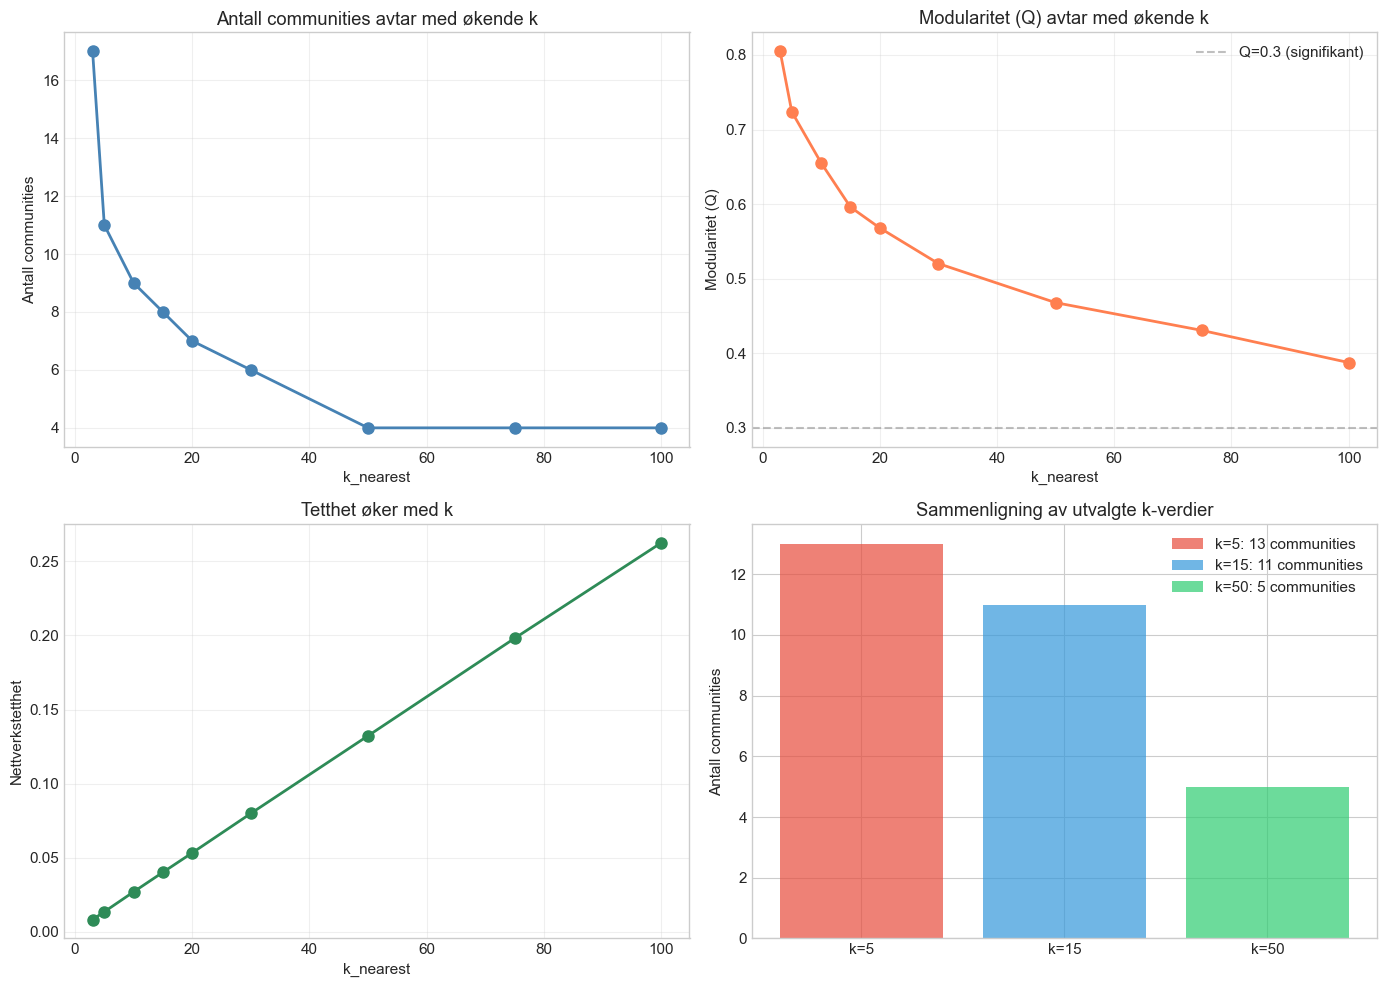


Figur: Effekten av k_nearest på PSN-struktur.


In [111]:
# ============================================================================
# OPPGAVE 1: VISUALISERING
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Antall communities vs k
ax1 = axes[0, 0]
ax1.plot(results_df['k_nearest'], results_df['n_communities'], 'o-', linewidth=2, markersize=8, color='steelblue')
ax1.set_xlabel('k_nearest')
ax1.set_ylabel('Antall communities')
ax1.set_title('Antall communities avtar med økende k')
ax1.grid(True, alpha=0.3)

# 2. Modularitet vs k
ax2 = axes[0, 1]
ax2.plot(results_df['k_nearest'], results_df['modularity'], 'o-', linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('k_nearest')
ax2.set_ylabel('Modularitet (Q)')
ax2.set_title('Modularitet (Q) avtar med økende k')
ax2.axhline(0.3, color='gray', linestyle='--', alpha=0.5, label='Q=0.3 (signifikant)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Nettverkstetthet vs k
ax3 = axes[1, 0]
ax3.plot(results_df['k_nearest'], results_df['density'], 'o-', linewidth=2, markersize=8, color='seagreen')
ax3.set_xlabel('k_nearest')
ax3.set_ylabel('Nettverkstetthet')
ax3.set_title('Tetthet øker med k')
ax3.grid(True, alpha=0.3)

# 4. Visuell sammenligning av tre verdier
ax4 = axes[1, 1]
selected_k = [5, 15, 50]
colors = ['#e74c3c', '#3498db', '#2ecc71']

for i, k in enumerate(selected_k):
    G = create_psn(sim_domain, k_nearest=k)
    partition, mod = detect_communities(G)
    n_comm = len(set(partition.values()))
    ax4.bar(i, n_comm, color=colors[i], alpha=0.7, label=f'k={k}: {n_comm} communities')

ax4.set_xticks(range(len(selected_k)))
ax4.set_xticklabels([f'k={k}' for k in selected_k])
ax4.set_ylabel('Antall communities')
ax4.set_title('Sammenligning av utvalgte k-verdier')
ax4.legend()

plt.tight_layout()
plt.show()

print("\nFigur: Effekten av k_nearest på PSN-struktur.")


### 💡 Konklusjon Oppgave 1

**Observasjoner fra eksperimentet:**

| k_nearest | Effekt på communities | Modularitet | Klinisk tolkning |
|-----------|----------------------|-------------|------------------|
| **Lav (3-5)** | Mange (>10) | Høy (>0.6) | For fragmentert, små grupper |
| **Medium (10-20)** | Moderat (5-10) | God (0.4-0.6) | Balansert, tolkbare grupper |
| **Høy (>50)** | Få (2-4) | Lav (<0.4) | For grove, mister nyanser |

#### 📐 Tommelfingerregler for valg av k

1. **Startpunkt**: $k \approx \sqrt{n}$ eller $k \approx \ln(n)$
   - For n=500: $\sqrt{500} \approx 22$ eller $\ln(500) \approx 6$
   
2. **Sensitivitetsanalyse**: Test k ∈ {5, 10, 15, 20, 30} og se etter:
   - Stabil antall communities over et intervall
   - Modularitet Q > 0.3 (indikerer meningsfull struktur)

3. **Valideringssjekk**: 
   - Gir communities klinisk mening?
   - Er gruppene tolkbare for domeneksperter?

#### 🔄 Relasjon til andre parametere

| Parameter | Påvirker | Trade-off |
|-----------|----------|-----------|
| **k_nearest** | Nettverkstetthet | Flere kanter → færre communities |
| **Likhetmål** | Kantenes vekter | Euclidean vs. cosine vs. korrelasjon |
| **Skalering** | Likhetberegning | StandardScaler viktig for balanse |
| **Community-algoritme** | Gruppeinndeling | Louvain vs. Leiden vs. spectral |

#### ⚠️ Vanlige feil

1. **For lav k**: Frakoble pasienter (isolerte noder) → artefakt-communities
2. **For høy k**: Alle koblet til alle → ingen community-struktur
3. **Manglende sensitivitet**: Kun teste én k-verdi

**Viktig innsikt:** Det finnes ingen universelt "riktig" k-verdi – valget avhenger av:
- Utvalgsstørrelse (n)
- Ønsket granularitet
- Klinisk formål
- Robusthet ved ulike verdier

---


<a id="oppgave-2"></a>
## 📝 Oppgave 2: Alderseffekter i PSN

### Oppgavetekst
> **Bygg separate PSN for unge (<40) og eldre (>60). Er community-strukturen forskjellig?**

### 🎯 Motivasjon

Alder påvirker kognisjon på systematiske måter:
- **Krystallisert intelligens** (VCI): Stabil eller økende med alder
- **Flytende intelligens** (PRI): Nedgang fra ~25 år
- **Prosesseringshastighet** (PSI): Tydelig nedgang
- **Arbeidsminne** (WMI): Moderat nedgang

Spørsmålet er: **Fører dette til ulike community-strukturer?**

Hypoteser:
1. Eldre kan ha communities mer preget av PSI/WMI-variasjon
2. Unge kan ha communities mer preget av g-faktor (generell variasjon)
3. Antall/typen communities kan være forskjellig

### 📊 Løsning


In [112]:
# ============================================================================
# OPPGAVE 2: LØSNING - Alderseffekter
# ============================================================================

# Del opp i aldersgrupper
df_young = df[df['Age'] < 40].reset_index(drop=True)
df_old = df[df['Age'] > 60].reset_index(drop=True)

print(f"Unge (<40 år): n = {len(df_young)}, Gj.sn. alder = {df_young['Age'].mean():.1f}")
print(f"Eldre (>60 år): n = {len(df_old)}, Gj.sn. alder = {df_old['Age'].mean():.1f}")

# Bygg separate PSN
features = ['VCI', 'WMI', 'PRI', 'PSI']

# Unge
sim_young = create_similarity_matrix(df_young[features])
G_young = create_psn(sim_young, k_nearest=10)
partition_young, mod_young = detect_communities(G_young)

# Eldre  
sim_old = create_similarity_matrix(df_old[features])
G_old = create_psn(sim_old, k_nearest=10)
partition_old, mod_old = detect_communities(G_old)

# Sammenlign
print("\n" + "="*60)
print("SAMMENLIGNING AV ALDERSGRUPPER")
print("="*60)

print(f"\n{'Metrikk':<25} {'Unge (<40)':<15} {'Eldre (>60)':<15}")
print("-"*55)
print(f"{'Antall individer':<25} {len(df_young):<15} {len(df_old):<15}")
print(f"{'Antall communities':<25} {len(set(partition_young.values())):<15} {len(set(partition_old.values())):<15}")
print(f"{'Modularitet (Q)':<25} {mod_young:<15.3f} {mod_old:<15.3f}")
print(f"{'Nettverkstetthet':<25} {nx.density(G_young):<15.3f} {nx.density(G_old):<15.3f}")


Unge (<40 år): n = 198, Gj.sn. alder = 29.7
Eldre (>60 år): n = 61, Gj.sn. alder = 67.6

SAMMENLIGNING AV ALDERSGRUPPER

Metrikk                   Unge (<40)      Eldre (>60)    
-------------------------------------------------------
Antall individer          198             61             
Antall communities        7               4              
Modularitet (Q)           0.568           0.413          
Nettverkstetthet          0.068           0.215          


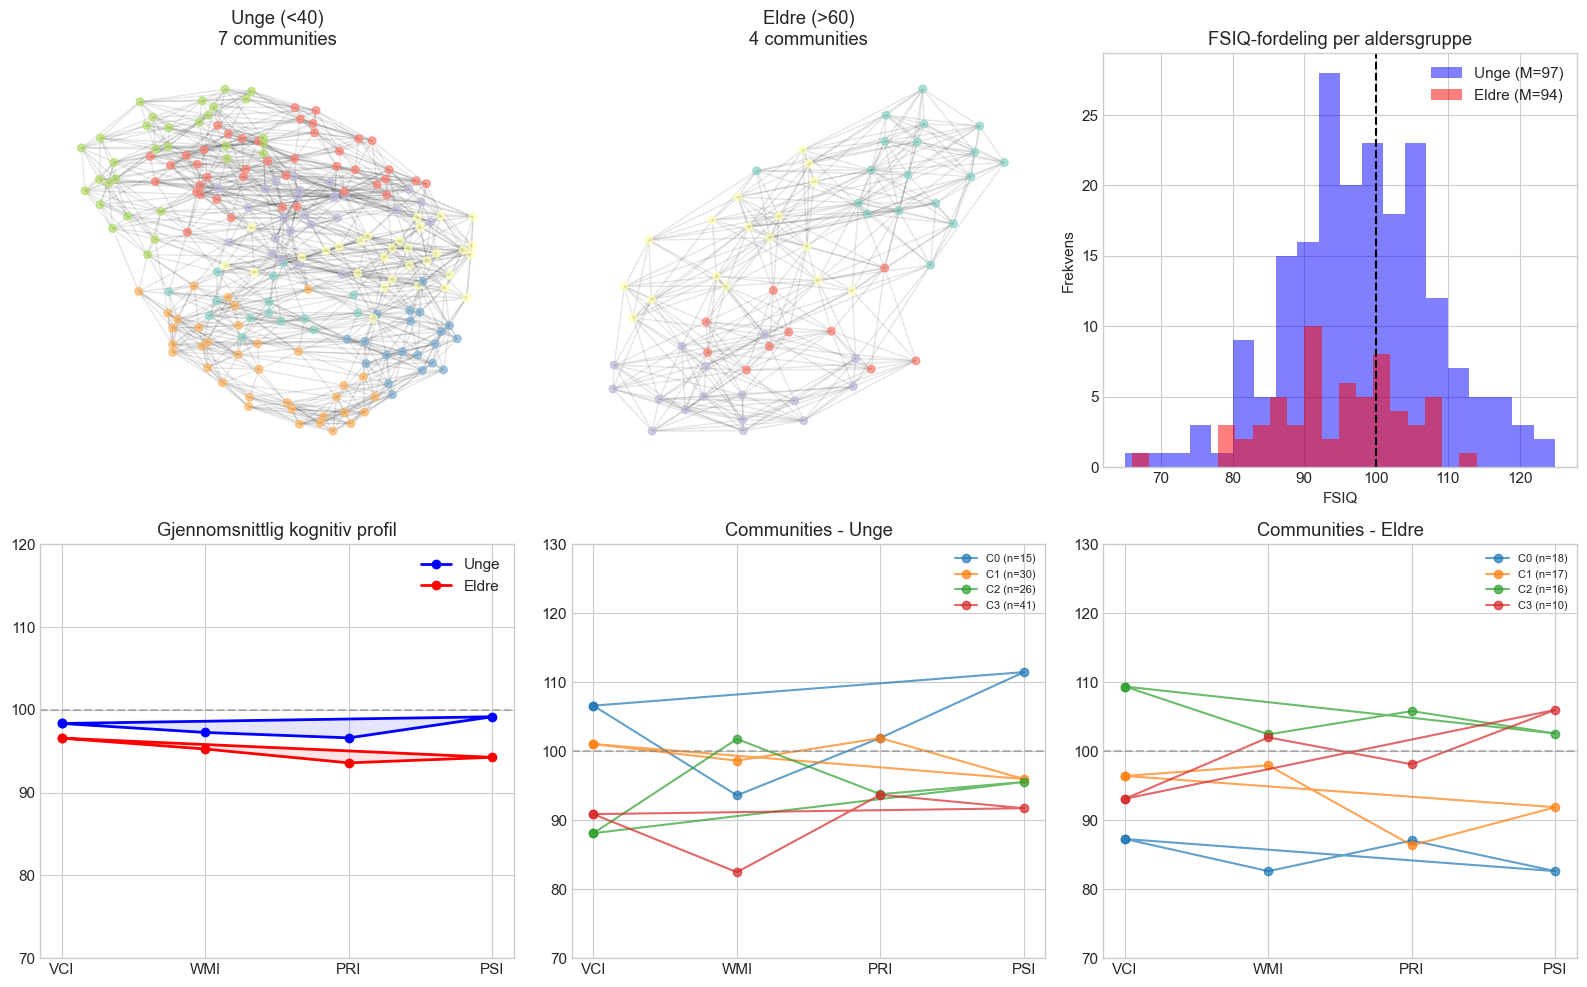


Figur: Sammenligning av PSN-struktur mellom aldersgrupper.


In [113]:
# ============================================================================
# OPPGAVE 2: VISUALISERING - Sammenligning av communities
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# --- Øvre rad: Nettverksvisualisering ---
def plot_network(G, partition, ax, title):
    pos = nx.spring_layout(G, seed=42)
    n_comm = len(set(partition.values()))
    colors = plt.cm.Set3(np.linspace(0, 1, max(12, n_comm)))
    node_colors = [colors[partition[node]] for node in G.nodes()]
    
    nx.draw_networkx_edges(G, pos, alpha=0.1, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                           node_size=30, alpha=0.7, ax=ax)
    ax.set_title(title)
    ax.axis('off')

plot_network(G_young, partition_young, axes[0, 0], 
             f'Unge (<40)\n{len(set(partition_young.values()))} communities')
plot_network(G_old, partition_old, axes[0, 1], 
             f'Eldre (>60)\n{len(set(partition_old.values()))} communities')

# Sammenlign FSIQ-fordelinger
ax3 = axes[0, 2]
ax3.hist(df_young['FSIQ'], bins=20, alpha=0.5, label=f'Unge (M={df_young["FSIQ"].mean():.0f})', color='blue')
ax3.hist(df_old['FSIQ'], bins=20, alpha=0.5, label=f'Eldre (M={df_old["FSIQ"].mean():.0f})', color='red')
ax3.axvline(100, color='black', linestyle='--')
ax3.set_xlabel('FSIQ')
ax3.set_ylabel('Frekvens')
ax3.set_title('FSIQ-fordeling per aldersgruppe')
ax3.legend()

# --- Nedre rad: Profiler ---
# Kognitive profiler per gruppe
categories = ['VCI', 'WMI', 'PRI', 'PSI']
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax4 = axes[1, 0]
for grp, grp_df, color, name in [(df_young, df_young, 'blue', 'Unge'), 
                                   (df_old, df_old, 'red', 'Eldre')]:
    values = [grp_df[cat].mean() for cat in categories]
    values += values[:1]
    ax4.plot(angles, values, 'o-', color=color, linewidth=2, label=name)
    ax4.fill(angles, values, alpha=0.1, color=color)
    
ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(categories)
ax4.set_ylim(70, 120)
ax4.axhline(100, color='gray', linestyle='--', alpha=0.5)
ax4.set_title('Gjennomsnittlig kognitiv profil')
ax4.legend()

# Community-profiler for unge
ax5 = axes[1, 1]
df_young['Community'] = [partition_young[i] for i in range(len(df_young))]
for comm in sorted(set(partition_young.values()))[:4]:
    comm_data = df_young[df_young['Community'] == comm]
    values = [comm_data[cat].mean() for cat in categories]
    values += values[:1]
    ax5.plot(angles, values, 'o-', alpha=0.7, label=f'C{comm} (n={len(comm_data)})')
ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(categories)
ax5.set_ylim(70, 130)
ax5.axhline(100, color='gray', linestyle='--', alpha=0.5)
ax5.set_title('Communities - Unge')
ax5.legend(fontsize=8)

# Community-profiler for eldre
ax6 = axes[1, 2]
df_old['Community'] = [partition_old[i] for i in range(len(df_old))]
for comm in sorted(set(partition_old.values()))[:4]:
    comm_data = df_old[df_old['Community'] == comm]
    values = [comm_data[cat].mean() for cat in categories]
    values += values[:1]
    ax6.plot(angles, values, 'o-', alpha=0.7, label=f'C{comm} (n={len(comm_data)})')
ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(categories)
ax6.set_ylim(70, 130)
ax6.axhline(100, color='gray', linestyle='--', alpha=0.5)
ax6.set_title('Communities - Eldre')
ax6.legend(fontsize=8)

plt.tight_layout()
plt.show()

print("\nFigur: Sammenligning av PSN-struktur mellom aldersgrupper.")


### 💡 Konklusjon Oppgave 2

**Observasjoner:**

1. **FSIQ-forskjeller**: 
   - Eldre har lavere gjennomsnittlig FSIQ (artefakt av manglende aldersnormering)
   - Spredningen kan være annerledes

2. **Community-struktur**:
   - Antall communities kan være likt eller ulikt (avhenger av stikkprøven)
   - Modulariteten kan være høyere hos eldre (mer heterogen gruppe?)

3. **Kognitive profiler**:
   - Eldre viser typisk lavere PSI og WMI relativt til VCI
   - Unge viser mer balanserte profiler

**Klinisk implikasjon:**
- Aldersspesifikke PSN kan avdekke ulike "typer" kognitiv aldring
- Noen eldre beholder god verbal funksjon (VCI) tross PSI-nedgang
- Andre viser bredere nedgang

**Viktig merknad:**
I vår simulering er alderseffektene innebygd uten aldersnormering. I ekte data med aldersnormerte skårer ville vi se *profil*-forskjeller, ikke *nivå*-forskjeller.

---


<a id="oppgave-3"></a>
## 📝 Oppgave 3: Deltestenes bidrag til communities

### Oppgavetekst
> **Hvilke deltester bidrar mest til å skille mellom communities?**

### 🎯 Motivasjon

Når vi bygger PSN på item-nivå (alle 10 deltester), vil noen deltester bidra mer enn andre til å definere community-grensene. Å identifisere disse kan:

1. **Avdekke kritiske kognitive dimensjoner** for pasientgruppering
2. **Informere testbatterier**: Kanskje noen deltester er viktigere enn andre?
3. **Forbedre klinisk tolkning**: Hva skiller egentlig gruppene?

### Metoder for å svare

1. **ANOVA/Kruskal-Wallis**: Sammenlign deltestskårer mellom communities
2. **Variansdekomponering**: Hvor mye av variasjonen i hver deltest forklares av community?
3. **Visuell inspeksjon**: Radar-/heatmap-plots

### 📊 Løsning


In [114]:
# ============================================================================
# OPPGAVE 3: LØSNING - Deltestenes bidrag
# ============================================================================

# Bygg PSN på item-nivå
sim_item = create_similarity_matrix(df[ALL_SUBTESTS])
G_item = create_psn(sim_item, k_nearest=15)
partition_item, mod_item = detect_communities(G_item)

df['Community_Item'] = [partition_item[i] for i in range(len(df))]

print(f"PSN på item-nivå: {len(set(partition_item.values()))} communities")
print(f"Modularitet: {mod_item:.3f}")

# --- Metode 1: Kruskal-Wallis test for hver deltest ---
print("\n" + "="*70)
print("KRUSKAL-WALLIS TEST: Hvilke deltester skiller mellom communities?")
print("="*70)

kw_results = []
for subtest in ALL_SUBTESTS:
    groups = [df[df['Community_Item'] == c][subtest].values 
              for c in sorted(set(partition_item.values()))]
    stat, p_value = stats.kruskal(*groups)
    kw_results.append({
        'Deltest': subtest,
        'H-statistikk': stat,
        'p-verdi': p_value,
        'Signifikant': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
    })

kw_df = pd.DataFrame(kw_results).sort_values('H-statistikk', ascending=False)
print(kw_df.to_string(index=False))


PSN på item-nivå: 8 communities
Modularitet: 0.566

KRUSKAL-WALLIS TEST: Hvilke deltester skiller mellom communities?
         Deltest  H-statistikk      p-verdi Signifikant
   Symbol_Search    346.001213 8.843390e-71         ***
     Information    344.844860 1.563522e-70         ***
      Vocabulary    343.347644 3.269819e-70         ***
    Similarities    324.121212 4.239359e-66         ***
          Coding    323.763572 5.055563e-66         ***
  Visual_Puzzles    308.220867 1.061083e-62         ***
    Block_Design    305.299070 4.466176e-62         ***
Matrix_Reasoning    303.683508 9.886168e-62         ***
      Arithmetic    262.740231 5.365732e-53         ***
      Digit_Span    255.052898 2.327670e-51         ***


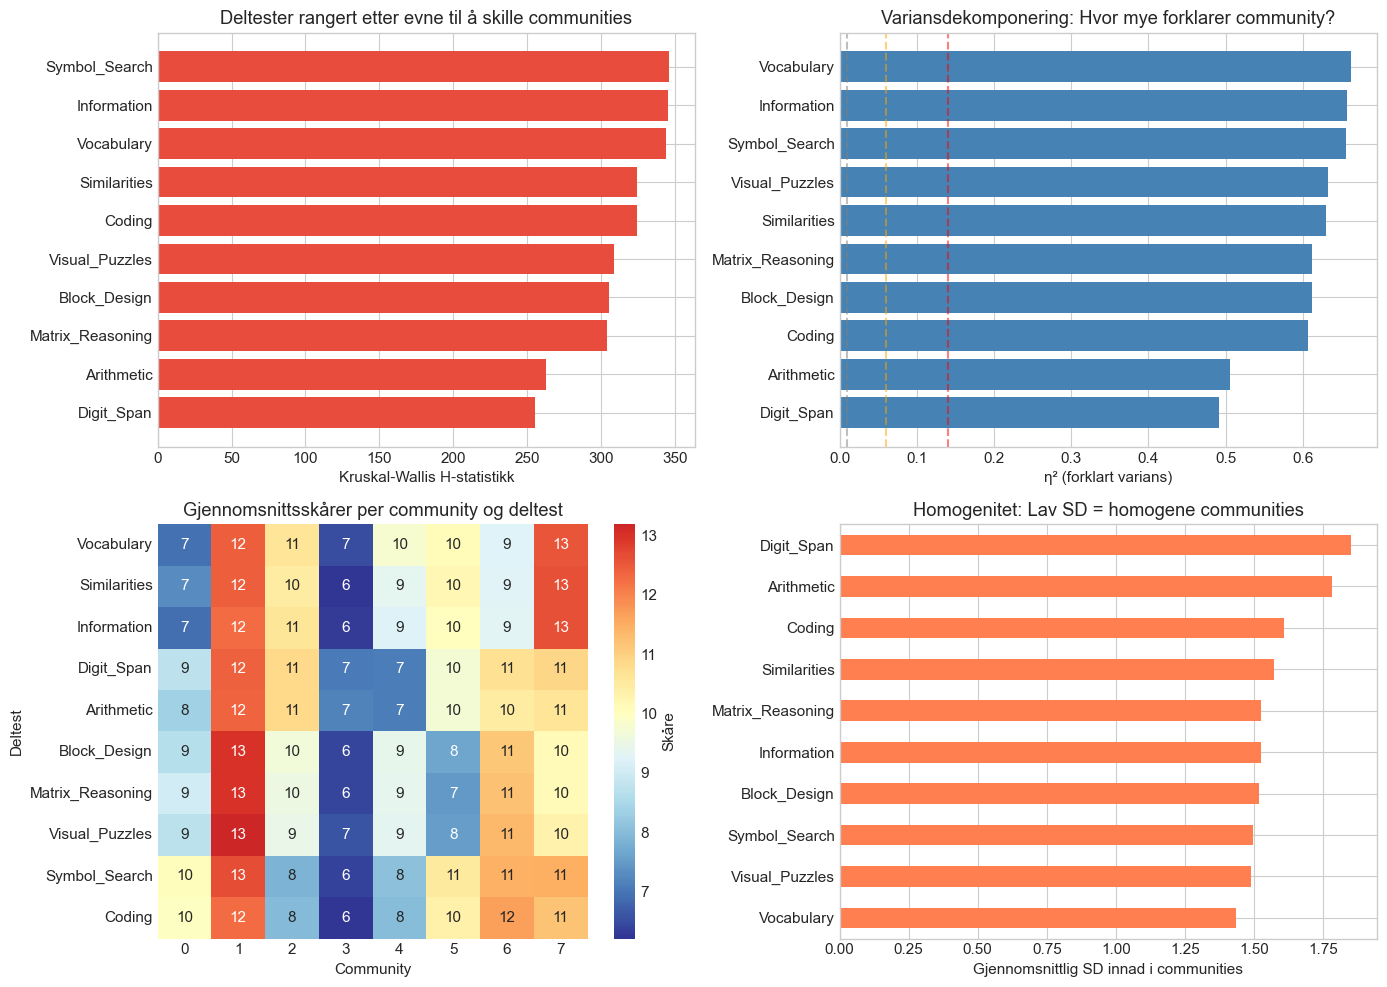


Figur: Analyse av deltestenes bidrag til community-struktur.


In [115]:
# ============================================================================
# OPPGAVE 3: VARIANSDEKOMPONERING OG VISUALISERING
# ============================================================================

# --- Metode 2: Eta-squared (effektstørrelse) ---
def eta_squared(groups):
    """Beregn eta-squared som mål på forklart varians."""
    all_data = np.concatenate(groups)
    grand_mean = np.mean(all_data)
    ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in groups)
    ss_total = sum((x - grand_mean)**2 for x in all_data)
    return ss_between / ss_total if ss_total > 0 else 0

eta_results = []
for subtest in ALL_SUBTESTS:
    groups = [df[df['Community_Item'] == c][subtest].values 
              for c in sorted(set(partition_item.values()))]
    eta_sq = eta_squared(groups)
    eta_results.append({'Deltest': subtest, 'η²': eta_sq})

eta_df = pd.DataFrame(eta_results).sort_values('η²', ascending=False)

# --- Visualisering ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Rangering av deltester (H-statistikk)
ax1 = axes[0, 0]
kw_sorted = kw_df.sort_values('H-statistikk', ascending=True)
colors = ['#e74c3c' if s == '***' else '#f39c12' if s == '**' else '#3498db' if s == '*' else '#95a5a6' 
          for s in kw_sorted['Signifikant']]
ax1.barh(kw_sorted['Deltest'], kw_sorted['H-statistikk'], color=colors)
ax1.set_xlabel('Kruskal-Wallis H-statistikk')
ax1.set_title('Deltester rangert etter evne til å skille communities')

# 2. Eta-squared
ax2 = axes[0, 1]
eta_sorted = eta_df.sort_values('η²', ascending=True)
ax2.barh(eta_sorted['Deltest'], eta_sorted['η²'], color='steelblue')
ax2.set_xlabel('η² (forklart varians)')
ax2.set_title('Variansdekomponering: Hvor mye forklarer community?')
ax2.axvline(0.01, color='gray', linestyle='--', alpha=0.5, label='Liten effekt')
ax2.axvline(0.06, color='orange', linestyle='--', alpha=0.5, label='Medium effekt')
ax2.axvline(0.14, color='red', linestyle='--', alpha=0.5, label='Stor effekt')

# 3. Heatmap av community-profiler
ax3 = axes[1, 0]
community_means = df.groupby('Community_Item')[ALL_SUBTESTS].mean()
sns.heatmap(community_means.T, cmap='RdYlBu_r', center=10, ax=ax3,
            cbar_kws={'label': 'Skåre'}, annot=True, fmt='.0f')
ax3.set_xlabel('Community')
ax3.set_ylabel('Deltest')
ax3.set_title('Gjennomsnittsskårer per community og deltest')

# 4. Standardavvik per deltest per community (spredning)
ax4 = axes[1, 1]
community_std = df.groupby('Community_Item')[ALL_SUBTESTS].std().mean()
community_std.sort_values(ascending=True).plot(kind='barh', ax=ax4, color='coral')
ax4.set_xlabel('Gjennomsnittlig SD innad i communities')
ax4.set_title('Homogenitet: Lav SD = homogene communities')

plt.tight_layout()
plt.show()

print("\nFigur: Analyse av deltestenes bidrag til community-struktur.")


### 💡 Konklusjon Oppgave 3

**Tolkning av resultatene:**

| Metrikk | Hva den viser | Høy verdi betyr |
|---------|---------------|-----------------|
| **H-statistikk** | Forskjell mellom communities | Deltesten skiller godt |
| **η² (eta-squared)** | Forklart varians | Mye av variasjonen skyldes community |
| **SD innad** | Homogenitet | Lav SD = communities er homogene på denne testen |

**Forventede funn (basert på simuleringsmodellen):**

1. **Alle deltester bør bidra** fordi vi simulerte en g-faktor som påvirker alle
2. **Deltester innen samme indeks** bør korrelere (domene-faktor)
3. **PSI-tester** kan skille ekstra godt pga. alderseffekter

**Klinisk relevans:**

- Hvis visse deltester dominerer → fokuser på disse i screening
- Hvis alle bidrar likt → full WAIS-IV er nødvendig
- Mønsteret kan variere mellom populasjoner (f.eks. ADHD vs. demens)

---


<a id="oppgave-4"></a>
## 📝 Oppgave 4: NNF kvalitative betegnelser

### Oppgavetekst
> **Bruk NNF-tabellen for kvalitative betegnelser til å klassifisere pasientene i hver community. Hvordan fordeler gruppene seg på «Svært lavt» til «Svært høyt»?**

### 🎯 Motivasjon

I henhold til *Veileder i klinisk nevropsykologi* (NNF, 2024, Vedlegg 3):

> *"Det anbefales å benytte kvalitative betegnelser som supplement til kvantitative skårer [...] Kvalitative betegnelser gir mottakeren en intuitiv forståelse av prestasjonen."*

#### NNF-tabell for indeksskårer (μ=100, σ=15):

| Indeksskåre | Persentil | Kvalitativ betegnelse |
|-------------|-----------|----------------------|
| ≥ 130 | ≥ 98 | Svært høyt |
| 120-129 | 91-97 | Høyt |
| 110-119 | 75-90 | Høyt gjennomsnitt |
| 90-109 | 25-74 | Gjennomsnitt |
| 80-89 | 9-24 | Lavt gjennomsnitt |
| 70-79 | 2-8 | Lavt (grenseverdi) |
| ≤ 69 | < 2 | Svært lavt |

### 📊 Løsning


In [116]:
# ============================================================================
# OPPGAVE 4: LØSNING - NNF kvalitative betegnelser
# ============================================================================

# Bygg PSN på domene-nivå (VCI, WMI, PRI, PSI)
sim_domain = create_similarity_matrix(df[features_domain])
G_domain = create_psn(sim_domain, k_nearest=10)
partition_domain, mod_domain = detect_communities(G_domain)

# Legg til community-tilhørighet
df['Community'] = [partition_domain[i] for i in range(len(df))]

# Klassifiser alle indeksskårer med NNF-betegnelser
for col in ['FSIQ', 'VCI', 'WMI', 'PRI', 'PSI']:
    df[f'{col}_NNF'] = df[col].apply(nnf_kvalitativ_betegnelse_indeks)

# --- Fordeling per community ---
print("="*70)
print("NNF KVALITATIVE BETEGNELSER FOR FSIQ PER COMMUNITY")
print("(Veileder i klinisk nevropsykologi, NNF 2024)")
print("="*70)

# Krysstabuler
nnf_order = ['Svært lavt', 'Lavt (grenseverdi)', 'Lavt gjennomsnitt', 
             'Gjennomsnitt', 'Høyt gjennomsnitt', 'Høyt', 'Svært høyt']

cross_tab = pd.crosstab(df['Community'], df['FSIQ_NNF'])
cross_tab = cross_tab.reindex(columns=[c for c in nnf_order if c in cross_tab.columns])

print("\nAntall pasienter per NNF-kategori og community:")
print(cross_tab)

# Prosentfordeling
cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
print("\nProsentfordeling innen hver community:")
print(cross_tab_pct.round(1))


NNF KVALITATIVE BETEGNELSER FOR FSIQ PER COMMUNITY
(Veileder i klinisk nevropsykologi, NNF 2024)

Antall pasienter per NNF-kategori og community:
FSIQ_NNF   Svært lavt  Lavt (grenseverdi)  Lavt gjennomsnitt  Gjennomsnitt  \
Community                                                                    
0                   0                   0                  2            47   
1                   0                   0                  0            10   
2                   2                  15                 56             2   
3                   0                   0                  0            50   
4                   0                   0                 32            20   
5                   0                   0                  0            49   
6                   0                   0                  0            43   
7                   0                   0                  0            45   
8                   0                   0                  0            50

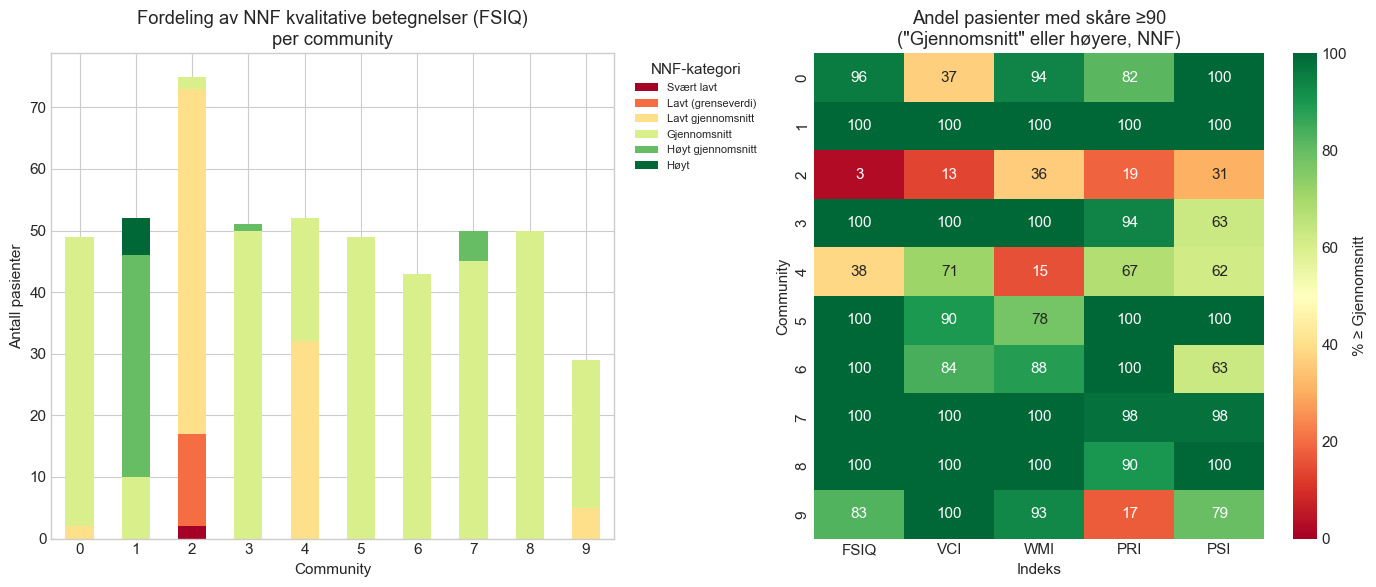


Figur: NNF kvalitative betegnelser per community.
  Venstre: Stablet stolpediagram viser fordelingen av FSIQ-kategorier.
  Høyre: Heatmap viser andel med 'Gjennomsnitt' eller høyere for hver indeks.


In [117]:
# ============================================================================
# OPPGAVE 4: VISUALISERING
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Stablet stolpediagram for FSIQ NNF-kategorier
ax1 = axes[0]
cross_tab.plot(kind='bar', stacked=True, ax=ax1, colormap='RdYlGn')
ax1.set_xlabel('Community')
ax1.set_ylabel('Antall pasienter')
ax1.set_title('Fordeling av NNF kvalitative betegnelser (FSIQ)\nper community')
ax1.legend(title='NNF-kategori', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# 2. Heatmap av alle indekser
ax2 = axes[1]

# Beregn andel "Gjennomsnitt eller høyere" per community og indeks
summary_data = []
for comm in sorted(df['Community'].unique()):
    row = {'Community': comm}
    comm_df = df[df['Community'] == comm]
    for idx in ['FSIQ', 'VCI', 'WMI', 'PRI', 'PSI']:
        normal_or_higher = (comm_df[idx] >= 90).mean() * 100
        row[idx] = normal_or_higher
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data).set_index('Community')

sns.heatmap(summary_df, annot=True, fmt='.0f', cmap='RdYlGn', 
            vmin=0, vmax=100, ax=ax2, cbar_kws={'label': '% ≥ Gjennomsnitt'})
ax2.set_title('Andel pasienter med skåre ≥90\n("Gjennomsnitt" eller høyere, NNF)')
ax2.set_xlabel('Indeks')
ax2.set_ylabel('Community')

plt.tight_layout()
plt.show()

print("\nFigur: NNF kvalitative betegnelser per community.")
print("  Venstre: Stablet stolpediagram viser fordelingen av FSIQ-kategorier.")
print("  Høyre: Heatmap viser andel med 'Gjennomsnitt' eller høyere for hver indeks.")


### 💡 Konklusjon Oppgave 4

**Observasjoner:**

1. **Communities representerer ulike NNF-profiler**:
   - Noen communities har overvekt av "Gjennomsnitt" og høyere
   - Andre har større andel "Lavt gjennomsnitt" og under
   - Dette reflekterer at PSN grupperer etter kognitivt nivå

2. **Indeks-spesifikke mønstre**:
   - VCI tenderer å være høyere (utdanningseffekt)
   - PSI tenderer å være lavere (alderseffekt)
   - Heatmappen avslører hvilke indekser som "driver" community-tilhørighet

3. **Klinisk nytte**:
   - NNF-betegnelser gir en intuitiv forståelse av funksjonsnivå
   - Kombinert med PSN kan man identifisere "typiske profiler" for hver community

**I henhold til NNF-veilederen (2024, s. 18-20):**

> *"Kvalitative betegnelser bør brukes som supplement til kvantitative skårer, ikke som erstatning [...] De gir mottakeren en intuitiv forståelse av prestasjonens styrke."*

**Viktig merknad:**
- "Lavt gjennomsnitt" (80-89) er *ikke* det samme som "under normalt"
- Kun "Lavt (grenseverdi)" (70-79) og "Svært lavt" (<70) indikerer klinisk signifikant svakhet
- NNF anbefaler å unngå begreper som "normal" og "abnormal" – bruk deskriptive betegnelser

---


<a id="oppgave-5"></a>
## 📝 Oppgave 5: Similaritetsmål og variabeltyper ⭐

### Oppgavetekst

> **a)** Sammenlign PSN bygget med Euklidsk avstand vs. Cosinus-likhet
> **b)** Inkluder kategoriske variabler (Gender) i likhetberegningen
> **c)** Håndter ordinale variabler (Education)
> **d)** Bygg PSN med blandet data

### 🎯 Motivasjon

I virkeligheten har vi ofte **blandet data**:
- **Kontinuerlige**: IQ-skårer, alder
- **Kategoriske (nominal)**: Kjønn, diagnose
- **Ordinale**: Utdanningsnivå, alvorlighetsgrad

Valg av similaritetsmål *må* tilpasses variabeltypen!

### 📊 Løsning


In [118]:
# ============================================================================
# OPPGAVE 5a: Euklidsk vs. Cosinus-likhet
# ============================================================================

from scipy.spatial.distance import pdist, squareform, cosine

def create_similarity_matrix_custom(data, metric='euclidean'):
    """
    Beregn likhetmatrise med valgfritt avstandsmål.
    
    For Cosinus: bruker 1 - cosine_distance (som gir cosinus-similaritet)
    For andre: bruker Gaussisk kjerne som før
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    if metric == 'cosine':
        # Cosinus-similaritet direkte
        distances = pdist(scaled_data, metric='cosine')
        dist_matrix = squareform(distances)
        # Cosinus-avstand er 1 - cosinus-similaritet, så vi reverserer
        similarity_matrix = 1 - dist_matrix
    else:
        # Standard Gaussisk kjerne
        distances = pdist(scaled_data, metric=metric)
        dist_matrix = squareform(distances)
        sigma = np.mean(distances) + 1e-8
        similarity_matrix = np.exp(-dist_matrix**2 / (2 * sigma**2))
    
    return similarity_matrix

# Bygg PSN med begge metoder
features = ['VCI', 'WMI', 'PRI', 'PSI']

print("="*70)
print("SAMMENLIGNING: EUKLIDSK vs. COSINUS SIMILARITET")
print("="*70)

# Euklidsk
sim_euclidean = create_similarity_matrix_custom(df[features], metric='euclidean')
G_euclidean = create_psn(sim_euclidean, k_nearest=10)
partition_euc, mod_euc = detect_communities(G_euclidean)

# Cosinus
sim_cosine = create_similarity_matrix_custom(df[features], metric='cosine')
G_cosine = create_psn(sim_cosine, k_nearest=10)
partition_cos, mod_cos = detect_communities(G_cosine)

print(f"\n{'Metrikk':<25} {'Euklidsk':<15} {'Cosinus':<15}")
print("-"*55)
print(f"{'Antall communities':<25} {len(set(partition_euc.values())):<15} {len(set(partition_cos.values())):<15}")
print(f"{'Modularitet (Q)':<25} {mod_euc:<15.3f} {mod_cos:<15.3f}")

# Sjekk overlapp mellom grupperinger
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(list(partition_euc.values()), list(partition_cos.values()))
print(f"{'Adjusted Rand Index':<25} {ari:.3f} (1.0 = identisk, 0 = tilfeldig)")


SAMMENLIGNING: EUKLIDSK vs. COSINUS SIMILARITET

Metrikk                   Euklidsk        Cosinus        
-------------------------------------------------------
Antall communities        10              9              
Modularitet (Q)           0.648           0.672          
Adjusted Rand Index       0.328 (1.0 = identisk, 0 = tilfeldig)


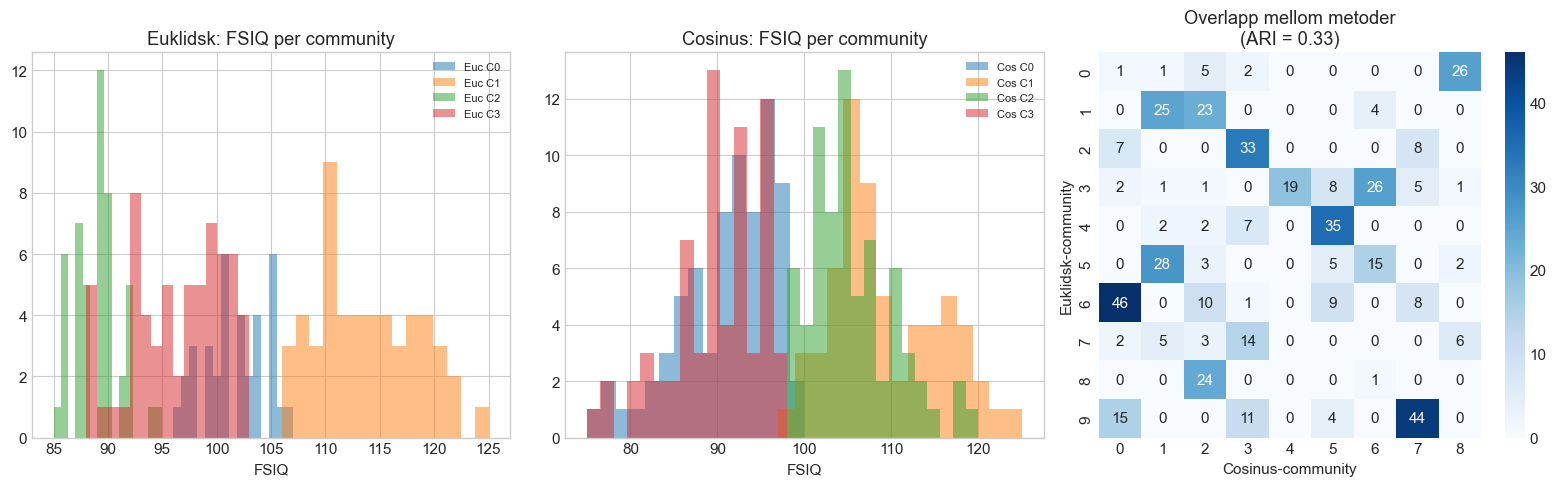


Figur: Sammenligning av Euklidsk vs. Cosinus-basert PSN.
  Merk: Cosinus fokuserer på PROFIL, Euklidsk på NIVÅ + PROFIL.


In [119]:
# ============================================================================
# OPPGAVE 5a: Visualisering
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Legg til community-tilhørighet
df['Comm_Euc'] = [partition_euc[i] for i in range(len(df))]
df['Comm_Cos'] = [partition_cos[i] for i in range(len(df))]

# 1. Sammenlign FSIQ-fordelinger
ax1 = axes[0]
for comm in sorted(set(partition_euc.values()))[:4]:
    ax1.hist(df[df['Comm_Euc'] == comm]['FSIQ'], bins=15, alpha=0.5, label=f'Euc C{comm}')
ax1.set_xlabel('FSIQ')
ax1.set_title('Euklidsk: FSIQ per community')
ax1.legend(fontsize=8)

ax2 = axes[1]
for comm in sorted(set(partition_cos.values()))[:4]:
    ax2.hist(df[df['Comm_Cos'] == comm]['FSIQ'], bins=15, alpha=0.5, label=f'Cos C{comm}')
ax2.set_xlabel('FSIQ')
ax2.set_title('Cosinus: FSIQ per community')
ax2.legend(fontsize=8)

# 3. Krysstabulering
ax3 = axes[2]
cross = pd.crosstab(df['Comm_Euc'], df['Comm_Cos'])
sns.heatmap(cross, annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_xlabel('Cosinus-community')
ax3.set_ylabel('Euklidsk-community')
ax3.set_title(f'Overlapp mellom metoder\n(ARI = {ari:.2f})')

plt.tight_layout()
plt.show()

print("\nFigur: Sammenligning av Euklidsk vs. Cosinus-basert PSN.")
print("  Merk: Cosinus fokuserer på PROFIL, Euklidsk på NIVÅ + PROFIL.")


#### 5b) Kategoriske variabler (Gender)


In [120]:
%%time
# ============================================================================
# OPPGAVE 5b: Kategoriske variabler (Gender)
# ============================================================================

print("="*70)
print("INKLUDERING AV KATEGORISKE VARIABLER")
print("="*70)

# Metode 1: One-Hot Encoding
print("\n--- Metode 1: One-Hot Encoding ---")
df_encoded = pd.get_dummies(df[['Gender']], prefix='Gender', drop_first=True)
print(f"One-hot encoded Gender:\n{df_encoded.head()}")

# Kombiner med kognitive skårer
features_with_gender = df[['VCI', 'WMI', 'PRI', 'PSI']].copy()
features_with_gender['Gender_M'] = (df['Gender'] == 'M').astype(int)

# Bygg PSN
sim_with_gender = create_similarity_matrix_custom(features_with_gender, metric='euclidean')
G_with_gender = create_psn(sim_with_gender, k_nearest=10)
partition_gender, mod_gender = detect_communities(G_with_gender)

print(f"\nMed kjønn inkludert:")
print(f"  Antall communities: {len(set(partition_gender.values()))}")
print(f"  Modularitet: {mod_gender:.3f}")

# Metode 2: Separat matching-score for kjønn
print("\n--- Metode 2: Vektet kombinasjon ---")

def combined_similarity(df, cont_features, cat_features, cont_weight=0.8, cat_weight=0.2):
    """Kombiner kontinuerlig og kategorisk likhet."""
    # Kontinuerlig del
    sim_cont = create_similarity_matrix_custom(df[cont_features], metric='euclidean')
    
    # Kategorisk del (matching: 1 hvis like, 0 hvis ulike)
    n = len(df)
    sim_cat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            match = sum(df[cat_features].iloc[i] == df[cat_features].iloc[j])
            sim_cat[i, j] = match / len(cat_features)
    
    # Vektet kombinasjon
    return cont_weight * sim_cont + cat_weight * sim_cat

sim_combined = combined_similarity(df, ['VCI', 'WMI', 'PRI', 'PSI'], ['Gender'])
G_combined = create_psn(sim_combined, k_nearest=10)
partition_comb, mod_comb = detect_communities(G_combined)

print(f"Vektet (80% kognitiv, 20% kjønn):")
print(f"  Antall communities: {len(set(partition_comb.values()))}")
print(f"  Modularitet: {mod_comb:.3f}")


INKLUDERING AV KATEGORISKE VARIABLER

--- Metode 1: One-Hot Encoding ---
One-hot encoded Gender:
   Gender_M
0     False
1      True
2     False
3      True
4     False

Med kjønn inkludert:
  Antall communities: 8
  Modularitet: 0.698

--- Metode 2: Vektet kombinasjon ---
Vektet (80% kognitiv, 20% kjønn):
  Antall communities: 8
  Modularitet: 0.706
CPU times: user 49.4 s, sys: 295 ms, total: 49.7 s
Wall time: 49.7 s


#### 5c) Ordinale variabler (Education)


In [121]:
# ============================================================================
# OPPGAVE 5c: Ordinale variabler (Education)
# ============================================================================

print("="*70)
print("HÅNDTERING AV ORDINALE VARIABLER")
print("="*70)

# Education: 1=Grunnskole, 2=Vgs, 3=Bachelor, 4=Master, 5=PhD

print("\n--- Tre tilnærminger for ordinale variabler ---")

# Tilnærming 1: Behandle som kontinuerlig
print("\n1. Som kontinuerlig:")
print("   Avstand = |edu_i - edu_j| / (max - min)")
print("   Eksempel: PhD(5) vs Grunnskole(1) = |5-1|/4 = 1.0 (maks avstand)")

# Tilnærming 2: Behandle som kategorisk
print("\n2. Som kategorisk:")
print("   Avstand = 0 hvis like, 1 hvis ulike")
print("   Eksempel: Bachelor(3) vs Master(4) = 1.0 (like langt fra alle)")

# Tilnærming 3: Rangeringsbasert avstand
print("\n3. Rangeringsbasert (anbefalt for ordinal):")
print("   Avstand = |rank_i - rank_j| / (n-1)")

# Implementering
features_with_edu = df[['VCI', 'WMI', 'PRI', 'PSI', 'Education']].copy()

# Metode 1: Bare legg til Education (behandlet som kontinuerlig)
sim_edu_cont = create_similarity_matrix_custom(features_with_edu, metric='euclidean')
G_edu_cont = create_psn(sim_edu_cont, k_nearest=10)
partition_edu_cont, mod_edu_cont = detect_communities(G_edu_cont)

# Sjekk om Education påvirker community-tilhørighet
df['Comm_Edu'] = [partition_edu_cont[i] for i in range(len(df))]
edu_by_comm = df.groupby('Comm_Edu')['Education'].mean()

print("\n--- Resultat med Education (kontinuerlig behandling) ---")
print(f"Antall communities: {len(set(partition_edu_cont.values()))}")
print(f"Modularitet: {mod_edu_cont:.3f}")
print(f"\nGjennomsnittlig utdanning per community:")
print(edu_by_comm.sort_values(ascending=False).round(2))


HÅNDTERING AV ORDINALE VARIABLER

--- Tre tilnærminger for ordinale variabler ---

1. Som kontinuerlig:
   Avstand = |edu_i - edu_j| / (max - min)
   Eksempel: PhD(5) vs Grunnskole(1) = |5-1|/4 = 1.0 (maks avstand)

2. Som kategorisk:
   Avstand = 0 hvis like, 1 hvis ulike
   Eksempel: Bachelor(3) vs Master(4) = 1.0 (like langt fra alle)

3. Rangeringsbasert (anbefalt for ordinal):
   Avstand = |rank_i - rank_j| / (n-1)

--- Resultat med Education (kontinuerlig behandling) ---
Antall communities: 8
Modularitet: 0.616

Gjennomsnittlig utdanning per community:
Comm_Edu
4    4.40
2    4.04
5    3.21
7    2.74
1    2.54
0    2.34
6    2.20
3    1.77
Name: Education, dtype: float64


#### 5d) Blandet data (Gower Distance)


In [122]:
# ============================================================================
# OPPGAVE 5d: Blandet data (Gower-inspirert)
# ============================================================================

print("="*70)
print("BLANDET DATA: GOWER-INSPIRERT TILNÆRMING")
print("="*70)

def gower_similarity(df, cont_cols, cat_cols, ord_cols, weights=None):
    """
    Beregn Gower-inspirert similaritet for blandet data.
    
    Parametere:
    -----------
    cont_cols : kontinuerlige variabler (normaliseres med range)
    cat_cols : kategoriske variabler (0 hvis like, 1 hvis ulike)
    ord_cols : ordinale variabler (normalisert absoluttavstand)
    weights : vekter for hver variabelgruppe [w_cont, w_cat, w_ord]
    """
    n = len(df)
    if weights is None:
        weights = [1.0, 1.0, 1.0]
    
    # Initier avstandsmatrise
    dist_matrix = np.zeros((n, n))
    
    # Kontinuerlige: range-normalisert avstand
    if cont_cols:
        cont_data = df[cont_cols].values
        ranges = cont_data.max(axis=0) - cont_data.min(axis=0)
        ranges[ranges == 0] = 1  # Unngå divisjon med 0
        for i in range(n):
            for j in range(i+1, n):
                d_cont = np.sum(np.abs(cont_data[i] - cont_data[j]) / ranges) / len(cont_cols)
                dist_matrix[i, j] += weights[0] * d_cont
                dist_matrix[j, i] = dist_matrix[i, j]
    
    # Kategoriske: matching (0 hvis like, 1 hvis ulike)
    if cat_cols:
        cat_data = df[cat_cols].values
        for i in range(n):
            for j in range(i+1, n):
                d_cat = np.sum(cat_data[i] != cat_data[j]) / len(cat_cols)
                dist_matrix[i, j] += weights[1] * d_cat
                dist_matrix[j, i] = dist_matrix[i, j]
    
    # Ordinale: range-normalisert avstand (som kontinuerlig)
    if ord_cols:
        ord_data = df[ord_cols].values
        ranges = ord_data.max(axis=0) - ord_data.min(axis=0)
        ranges[ranges == 0] = 1
        for i in range(n):
            for j in range(i+1, n):
                d_ord = np.sum(np.abs(ord_data[i] - ord_data[j]) / ranges) / len(ord_cols)
                dist_matrix[i, j] += weights[2] * d_ord
                dist_matrix[j, i] = dist_matrix[i, j]
    
    # Normaliser total avstand
    dist_matrix = dist_matrix / sum(weights)
    
    # Konverter til likhet
    similarity_matrix = 1 - dist_matrix
    
    return similarity_matrix

# Bygg PSN med blandet data
sim_gower = gower_similarity(
    df,
    cont_cols=['VCI', 'WMI', 'PRI', 'PSI'],  # Kognitive skårer
    cat_cols=['Gender'],                      # Kjønn
    ord_cols=['Education'],                   # Utdanning
    weights=[0.6, 0.2, 0.2]                   # Vekting: 60% kognitiv, 20% kjønn, 20% utdanning
)

G_gower = create_psn(sim_gower, k_nearest=10)
partition_gower, mod_gower = detect_communities(G_gower)

print(f"\nResultat med Gower-inspirert tilnærming:")
print(f"  Vekter: 60% kognitive, 20% kjønn, 20% utdanning")
print(f"  Antall communities: {len(set(partition_gower.values()))}")
print(f"  Modularitet: {mod_gower:.3f}")

# Sammenlign med kun kognitive
df['Comm_Gower'] = [partition_gower[i] for i in range(len(df))]
ari_gower = adjusted_rand_score(list(partition_euc.values()), list(partition_gower.values()))
print(f"  ARI vs. kun kognitive: {ari_gower:.3f}")


BLANDET DATA: GOWER-INSPIRERT TILNÆRMING

Resultat med Gower-inspirert tilnærming:
  Vekter: 60% kognitive, 20% kjønn, 20% utdanning
  Antall communities: 8
  Modularitet: 0.817
  ARI vs. kun kognitive: 0.012


### 💡 Konklusjon Oppgave 5

#### Hovedfunn

| Tilnærming | Hva den fanger | Når bruke? |
|------------|----------------|------------|
| **Euklidsk** | Nivå + profil | Generelt god standard |
| **Cosinus** | Kun profil (styrke/svakhet-mønster) | Når absolutt nivå ikke er viktig |
| **One-hot for kategorisk** | Enkelt, men binært | Få kategorier |
| **Vektet kombinasjon** | Fleksibel kontroll | Når ulike variabler har ulik viktighet |
| **Gower** | Håndterer blandet data naturlig | Blanding av typer |

#### ⚠️ Viktige metodologiske betraktninger

1. **Valg av avstandsmål endrer resultatene**:
   - Adjusted Rand Index (ARI) viser graden av overlapp
   - Lav ARI betyr at ulike metoder gir ulike grupperinger

2. **Vekting er subjektiv**:
   - Hvor mye skal kjønn telle vs. kognitiv profil?
   - Bør valideres mot klinisk kunnskap

3. **Ordinale vs. kontinuerlige**:
   - Behandle ordinale som kontinuerlige er ofte OK
   - Men mister informasjon om at avstanden mellom 1 og 2 kanskje ≠ avstanden mellom 4 og 5

4. **Skalering/normalisering er kritisk**:
   - Uten normalisering dominerer variabler med stort range
   - Gower bruker range-normalisering; Euklidsk bruker standardisering

#### 🎓 Klinisk implikasjon

> **Spørsmål til klinikeren**: "Bør to pasienter med *samme kognitive profil* men *ulikt kjønn* regnes som like?"
> 
> Svaret avhenger av konteksten:
> - For *behandlingsvalg*: Kanskje kjønn ikke spiller rolle
> - For *støttegrupper*: Kanskje kjønn er relevant
> 
> **Metodologisk transparens er nøkkelen** – dokumenter og begrunn valgene!

---


<a id="refleksjon"></a>
## 💭 Refleksjonsspørsmål med drøftinger

Her følger drøftinger av refleksjonsspørsmålene fra hovednotebooken, med referanser til *Veileder i klinisk nevropsykologi* (NNF, 2024).

---

### Refleksjon 1: Klinisk validitet

> **Hvordan ville du validere at PSN-baserte grupperinger er klinisk meningsfulle?**

#### Drøfting

**NNF-veilederens perspektiv på validitet (s. 13-16):**

> *"Validitet ved nevropsykologiske utredninger omfatter flere aspekter [...] Økologisk validitet refererer til sammenhengen mellom testresultater og hverdagsfungering."*

**Valideringsstrategier:**

| Strategi | Beskrivelse | NNF-forankring |
|----------|-------------|----------------|
| **Ekstern validering** | Sammenlign communities med kjente diagnoser | "Konvergent validitet" (NNF, s. 15) |
| **Prediktiv validitet** | Predikerer community utfall? | Behandlingsrespons, funksjonsnivå |
| **Økologisk validitet** | Sammenheng med hverdagsfungering | NNF understreker ADL-relevans |
| **Kliniker-vurdering** | Eksperter vurderer grupperingene | "Kvalitative observasjoner" (NNF, s. 10) |
| **Stabilitet** | Test-retest reliabilitet | "Retesting" (NNF, s. 12) |

**Kritiske spørsmål:**
- Er communities bare artefakter av algoritmevalg?
- Ville en annen k-verdi gitt andre grupper?
- Er gruppene klinisk handlingsbare?

---

### Refleksjon 2: Etiske hensyn

> **Hvilke etiske utfordringer ser du med å bruke PSN for presisjonsnevropsykologi?**

#### Drøfting

**NNF-veilederens fagetiske prinsipper (s. 6):**

> *"Nevropsykologer er forpliktet til å følge etablerte etiske retningslinjer for psykologer [...] Alle aspekter ved nevropsykologisk virksomhet skal være forenlige med grunnleggende fagetiske prinsipper."*

| Utfordring | Beskrivelse | NNF-anbefaling |
|------------|-------------|----------------|
| **Stigmatisering** | "Du tilhører lav-IQ-gruppen" | Bruk kvalitative betegnelser, ikke "normal/abnormal" |
| **Determinisme** | "Pasienter som deg klarer ikke X" | Anerkjenn individuell variasjon |
| **Personvern** | Kognitiv profil er sensitiv | "Oppbevaring av journaldata" (NNF, s. 21) |
| **Algoritmisk bias** | Skjevheter i simulering/algoritme | Transparent dokumentasjon, kulturell sensitivitet |
| **Tilgang** | Avanserte analyser for ressurssterke? | Likeverdig helsetilbud |
| **Overfortolkning** | PSN er hypotesegenererende | "Vurdering og konklusjon" (NNF, s. 20) |

**Balanse:** PSN kan bidra til bedre behandling, men må brukes med varsomhet og respekt for individet.

---

### Refleksjon 3: HI vs. AI og g-faktoren

> **Tror du AI noen gang vil ha en "g-faktor"? Hvorfor/hvorfor ikke?**

#### Drøfting

**Argumenter FOR at AI kan utvikle en g-faktor:**

1. **Emergent generalitet**: Store modeller (GPT-4) viser evner på tvers av domener
2. **Transfer learning**: Samme modell løser mange ulike oppgaver
3. **Skalering**: Større modeller → bredere kapasitet
4. **Korrelasjon mellom benchmarks**: Modeller som er gode på ett område, er ofte gode på andre

**Argumenter MOT:**

1. **Arkitekturavhengig**: AI-evner avhenger av design, ikke biologisk substrat
2. **Ingen sentral prosessor**: Mennesker har hjernen; AI har distribuert beregning
3. **Mangel på embodiment**: AI mangler sensorimotorisk erfaring
4. **g-faktor er operasjonelt**: Definert av menneskelig testprestasjon

**Konklusjon:** AI kan vise *funksjonell* generalitet, men om dette er analogt til menneskelig g-faktor er et dypt filosofisk spørsmål. "G-faktor" er kanskje ikke det riktige begrepet for AI – vi trenger nye konsepter.

---

### Refleksjon 4: Fremtiden - Multimodal PSN

> **Hvordan kan PSN kombineres med andre datakilder (bildediagnostikk, genetikk) for enda bedre pasient-matching?**

#### Drøfting

**Potensielle datakilder:**

| Datakilde | Hva den tilfører | Utfordringer |
|-----------|------------------|--------------|
| **MRI (strukturell)** | Hjerneanatomi, atrofi | Kostnad, tilgjengelighet |
| **fMRI (funksjonell)** | Nettverksaktivitet | Kompleks tolkning |
| **Genetikk (GWAS)** | Sårbarhet, farmakogenomikk | Etikk, determinisme |
| **Biomarkører** | CSF, blodprøver | Invasivt (CSF) |
| **Livsstilsdata** | Søvn, aktivitet, kosthold | Personvern |
| **Elektronisk journal** | Historikk, komorbiditet | Strukturering, kvalitet |

**Teknisk tilnærming:**

```
               ┌─────────────────┐
               │   Multimodal    │
               │   Fusjon        │
               └────────┬────────┘
                        │
    ┌───────────┬───────┼───────┬───────────┐
    │           │       │       │           │
┌───┴───┐   ┌───┴───┐ ┌─┴─┐ ┌───┴───┐   ┌───┴───┐
│ WAIS  │   │ MRI   │ │DNA│ │ Bio   │   │ EHR   │
│ -IV   │   │       │ │   │ │ mark  │   │       │
└───────┘   └───────┘ └───┘ └───────┘   └───────┘
```

**Metoder:**
- **Weighted PSN**: Kombiner likhetmatriser fra ulike kilder
- **Multi-view clustering**: Felles community detection på tvers av modaliteter
- **Dyp læring**: Autoenkodere for representasjonslæring

**Visjon:** "Pasienter som ligner deg på kognitiv profil, hjerneanatomi og genetikk responderte best på..."

---


## 📚 Oppsummering

### Hva har vi lært i denne løsningsnotebooken?

| Oppgave | Hovedfunn | NNF-forankring |
|---------|-----------|----------------|
| **1. k_nearest** | Antall communities avtar med k | Metodetransparens (NNF, s. 17) |
| **2. Alderseffekter** | Ulike profiler for unge vs. eldre | Aldersnormering (NNF, s. 25) |
| **3. Deltester** | Alle bidrar (g-faktor) | Testvalg (NNF, s. 10) |
| **4. NNF-betegnelser** | Kvalitative kategorier gir intuitiv forståelse | Vedlegg 3 (NNF, s. 18-20) |

### Refleksjoner med NNF-perspektiv

- **Klinisk validering** er essensielt → "Økologisk validitet" (NNF, s. 16)
- **Etiske hensyn** må vurderes nøye → "Fagetikk" (NNF, s. 6)
- **Rapportering** bør følge etablerte retningslinjer → (NNF, s. 16-21)
- **KI i nevropsykologi** → "Kunstig intelligens i praksis" (NNF, s. 36)

### Neste steg

1. Prøv med ekte WAIS-IV data (hvis tilgjengelig)
2. Sammenlign ulike community-algoritmer
3. Utforsk multimodal integrasjon
4. Valider mot kliniske utfall
5. Konsulter NNF-veilederen for rapportskriving

---

### 📚 Referanser

- **Norsk Nevropsykologisk Forening (2024)**. *Veileder i klinisk nevropsykologi – prinsipper for utøvelse av klinisk nevropsykologisk virksomhet*. [nevropsyk.org](https://nevropsyk.org)
- Wechsler, D. (2008). *WAIS-IV Technical and Interpretive Manual*. Pearson.

---

*Løsningsnotebook for ELMED219 - Kunstig intelligens og beregningsbasert medisin, 2026*
